In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from caveclient import CAVEclient

import matplotlib as mpl
from nglui.statebuilder.helpers import make_neuron_neuroglancer_link, make_synapse_neuroglancer_link

%matplotlib inline

from analysis_tools import set_stylesheet
set_stylesheet()

In [3]:
CAVE_DATASTACK_NAME = "v1dd"
CAVE_SERVER_ADDRESS = "https://globalv1.em.brain.allentech.org"

In [4]:
cave_setup = False # Only needs to be run once for setup!
client = CAVEclient(server_address=CAVE_SERVER_ADDRESS)

if cave_setup:
    # NOTE: Make sure you are signed into your @alleninstitute.org email!!!
    client.auth.setup_token(make_new=False)

# client.auth.save_token(token="yourtoken", overwrite=True)
# print("Auth token:", client.auth.token)

Tokens need to be acquired by hand. Please follow the following steps:
                1) Go to: https://globalv1.em.brain.allentech.org/auth/api/v1/user/token to view a list of your existing tokens.
                2) Log in with your Google credentials copy one of the tokens from the dictionary (the string under the key 'token').
                3a) Save it to your computer with: client.auth.save_token(token="PASTE_YOUR_TOKEN_HERE")
                or
                3b) Set it for the current session only with client.auth.token = "PASTE_YOUR_TOKEN_HERE"
                Note: If you need to save or load multiple tokens, please read the documentation for details.
                if you want to create a new token, or have no token use ```self.get_new_token``` instead
                or use this function with the keyword argument make_new=True


Once the client is setup, you should have access to the V1DD datastack.

Desired resolution takes `(a, b, c)` and instead of point positions being returned as `(x, y, z) voxels^3`, it returns `(x*xres/a, y*yres/b, z*zres/c)`, where `(xres, yres, zres) = (9, 9, 45) nm^3`

Here, we set desired resolution to `(1000, 1000, 1000)`, so point positions are returned in units of `microns^3` (since `1000 nm = 1 micron`).

**UPDATE**: `desired_resolution` is (currently) incompletely implemented so we're sticking with the default (nm) for now...

In [5]:
# MICRONS_RESOLUTION = [1e3]*3 # Since nm / 1e3 = microns
# client = CAVEclient(datastack_name=CAVE_DATASTACK_NAME, server_address=CAVE_SERVER_ADDRESS, desired_resolution=MICRONS_RESOLUTION)
client = CAVEclient(datastack_name=CAVE_DATASTACK_NAME, server_address=CAVE_SERVER_ADDRESS, desired_resolution=None)
print("Client version", client.materialize.version)

Client version 226


In [6]:
# Define the transform
from standard_transform import v1dd_transform_nm
transform_nm_to_microns = v1dd_transform_nm() # Transform from nm to oriented microns

def transform_position_to_microns(position, voxel_res=None, df=None):
    if df is not None:
        voxel_res = df.attrs["table_voxel_resolution"] # nm / voxel
        
    if voxel_res is not None:
        position = position * voxel_res # convert voxels -> nm
    
    input_1_point = len(position.shape) == 1
    position = transform_nm_to_microns.apply(position) # nm -> transformed microns
    
    # transform makes all arrays 2d; if input is 1d keep it 1d
    if input_1_point:
        position = position[0]
    
    return position

/opt/anaconda3/envs/v1dd-v3/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


### General notes
- `pt_root_id` can be used to cross-reference tables, but should not be stored anywhere since it can change with different materialize versions

List the tables

In [10]:
client.materialize.get_tables()

['ariadne_axon_task',
 'correspondance_pilot',
 'ariadne_multisoma_proofreading_v1',
 'ariadne_dendrite_proofreading_v2',
 'ariadne_axon_proofreading_v1',
 'synapses_v1dd',
 'multisoma_split_task',
 'ariadne_dendrite_task',
 'ophys_examples',
 'manual_central_types',
 'nucleus_detection_v0']

In [9]:
synapse_table = client.info.get_datastack_info()["synapse_table"] # "synapses_v1dd"
client.materialize.get_table_metadata(synapse_table)

{'valid': True,
 'table_name': 'synapses_v1dd',
 'created': '2021-11-26T19:49:30.927250',
 'id': 2063,
 'aligned_volume': 'v1dd',
 'schema': 'synapse',
 'schema_type': 'synapse',
 'user_id': '',
 'notice_text': None,
 'flat_segmentation_source': None,
 'write_permission': 'PRIVATE',
 'last_modified': '2022-10-27T17:28:14.043442',
 'description': '',
 'reference_table': None,
 'read_permission': 'PUBLIC',
 'voxel_resolution': [9.7, 9.7, 45.0]}

In [10]:
client.materialize.get_table_metadata("ariadne_axon_task")

{'valid': True,
 'table_name': 'ariadne_axon_task',
 'created': '2022-02-27T04:03:51.045554',
 'id': 2069,
 'aligned_volume': 'v1dd',
 'schema': 'cell_type_local',
 'schema_type': 'cell_type_local',
 'user_id': '5',
 'notice_text': None,
 'flat_segmentation_source': None,
 'write_permission': 'PRIVATE',
 'last_modified': '2022-11-09T22:06:33.205273',
 'description': 'Annotations correspond to axon tasks for Ariadne proofreaders. Possible types are `done`, `given`, `in_progress`, and `error`, corresponding to proofreading status. Classification system indicates statement of work. Managed by Casey Schneider-Mizell (caseys@alleninstitute.org).',
 'reference_table': None,
 'read_permission': 'PUBLIC',
 'voxel_resolution': [9.0, 9.0, 45.0]}

In [11]:
axon_proofreading = client.materialize.query_table("ariadne_axon_task", split_positions=True)
axon_proofreading

,id,valid,classification_system,cell_type,pt_position_x,pt_position_y,pt_position_z,pt_supervoxel_id,pt_root_id
0,1516,t,vip_task,submitted,100060,51069,5341,95006463965307181,864691132997795253
1,2154,t,emct_task,submitted,101328,74211,7109,95364080323840645,864691132767072268
2,1515,t,vip_task,submitted,103483,78772,7465,95928129855811010,864691132739753369
3,2887,t,emct_task,submitted,105242,94370,8719,96354259465513791,864691132896416742
4,1778,t,emct_task,submitted,100336,102397,8248,95089614934580633,864691132826063778
...,...,...,...,...,...,...,...,...,...
994,2097,t,emct_task,submitted,109735,116296,10122,97485588412306616,864691132737909147
995,2465,t,vip_task,clean,111614,77125,8441,97968479973780495,864691133045078560
996,3206,t,emct_task,clean,92757,63675,6348,93180037846832832,864691132826086291
997,3175,t,emct_task,clean,102759,65442,5565,95713724820159585,864691132700186936


Columns of `axon_proofreading` table
- `id`: 
- `valid`: uniformly "t"
- `classification_system`: 
- `cell_type`: 
- `pt_position_x`: 
- `pt_position_y`: 
- `pt_position_z`: 
- `pt_supervoxel_id`: supervoxel in the EM map
- `pt_root_id`: 

In [12]:
axon_proofreading.cell_type.value_counts()

submitted           626
clean               211
given                72
withdrawn            51
error                14
task_given           14
complete             10
initial_progress      1
Name: cell_type, dtype: int64

In [13]:
proofread_axons = axon_proofreading[axon_proofreading.cell_type.isin(["clean", "complete"])]
proofread_axons

,id,valid,classification_system,cell_type,pt_position_x,pt_position_y,pt_position_z,pt_supervoxel_id,pt_root_id
5,67,t,vip_task,complete,55058,47471,8431,83535465713803061,864691132720035937
27,68,t,vip_task,complete,79892,58797,7847,89871470121161389,864691132949256010
28,69,t,emct_task,complete,85857,68426,9515,91421987876227203,864691132806367265
29,70,t,vip_task,complete,66650,52945,6945,86492327157525518,864691133028846290
30,71,t,emct_task,complete,73467,79980,8278,88258280471811747,864691132653518844
...,...,...,...,...,...,...,...,...,...
987,3240,t,ssf_task,clean,97698,88498,4855,94452859793688434,864691132768277797
995,2465,t,vip_task,clean,111614,77125,8441,97968479973780495,864691133045078560
996,3206,t,emct_task,clean,92757,63675,6348,93180037846832832,864691132826086291
997,3175,t,emct_task,clean,102759,65442,5565,95713724820159585,864691132700186936


Text(0, 0.5, 'z ($\\mu$m)')

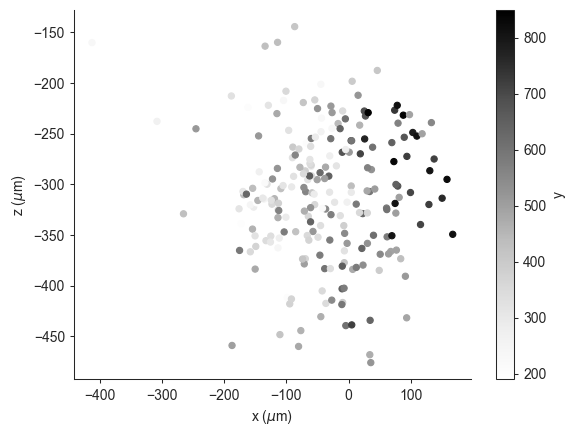

In [28]:
proofread_axon_positions = proofread_axons[["pt_position_x", "pt_position_y", "pt_position_z"]].values
positions_microns = transform_position_to_microns(proofread_axon_positions, df=proofread_axons)

df = pd.DataFrame(data=positions_microns, columns=["x", "y", "z"])
df.plot(kind="scatter", x="x", y="z", c="y")
plt.xlabel("x ($\mu$m)")
plt.ylabel("z ($\mu$m)")

In [29]:
client.materialize.get_table_metadata("ariadne_dendrite_task")

{'valid': True,
 'table_name': 'ariadne_dendrite_task',
 'created': '2022-02-27T04:04:05.827058',
 'id': 2065,
 'aligned_volume': 'v1dd',
 'schema': 'cell_type_local',
 'schema_type': 'cell_type_local',
 'user_id': '5',
 'notice_text': None,
 'flat_segmentation_source': None,
 'write_permission': 'PRIVATE',
 'last_modified': '2022-10-27T17:28:14.043442',
 'description': 'Annotations correspond to dendrite tasks for Ariadne proofreaders. Possible types are `done`, `given`, `in_progress`, and `error`, corresponding to proofreading status. Classification system indicates statement of work. Managed by Casey Schneider-Mizell (caseys@alleninstitute.org).',
 'reference_table': None,
 'read_permission': 'PUBLIC',
 'voxel_resolution': [9.0, 9.0, 45.0]}

In [30]:
dendrite_proofreading = client.materialize.query_table("ariadne_dendrite_task", split_positions=True)
dendrite_proofreading

,id,valid,classification_system,cell_type,pt_position_x,pt_position_y,pt_position_z,pt_supervoxel_id,pt_root_id
0,1,t,existing_task,complete,56196,78987,7640,83824774576942477,864691132846136019
1,2,t,existing_task,complete,62608,53481,7458,85507302245108559,864691132737187929
2,3,t,existing_task,complete,80469,54830,7699,90011245536643889,864691132949256010
3,4,t,existing_task,complete,69449,71865,6667,87200687456922208,864691132731114204
4,5,t,existing_task,complete,63853,57861,7495,85789876733553831,864691132831337070
...,...,...,...,...,...,...,...,...,...
2780,2781,t,existing_task,in_progress,94049,41885,13668,93526453668750691,864691132679475247
2781,2782,t,existing_task,in_progress,102451,50808,7284,95639714211748581,864691133311405136
2782,2783,t,existing_task,in_progress,101538,49821,7056,95428401753954753,864691133310678096
2783,2784,t,existing_task,in_progress,65354,39289,12415,86207416945025030,864691132698568779


In [37]:
dendrite_proofreading.cell_type.value_counts()

submitted      2478
in_progress     294
complete         13
Name: cell_type, dtype: int64

Text(0, 0.5, 'z ($\\mu$m)')

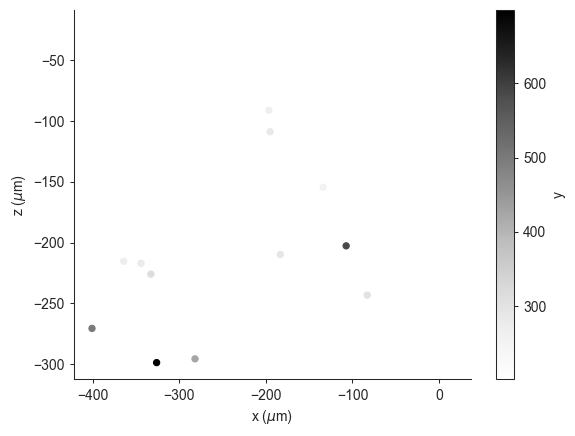

In [36]:
proofread_dendrite_positions = dendrite_proofreading[dendrite_proofreading.cell_type.isin(["complete"])][["pt_position_x", "pt_position_y", "pt_position_z"]].values
positions_microns = transform_position_to_microns(proofread_dendrite_positions, df=proofread_axons)

df = pd.DataFrame(data=positions_microns, columns=["x", "y", "z"])
df.plot(kind="scatter", x="x", y="z", c="y")
plt.xlabel("x ($\mu$m)")
plt.ylabel("z ($\mu$m)")

In [38]:
# Compute overlap with axon and dendrite proofreading
done_cell_type = ["clean", "complete"]
axon_done = axon_proofreading.pt_root_id[axon_proofreading.cell_type.isin(done_cell_type)]
dendrite_done = dendrite_proofreading.pt_root_id[dendrite_proofreading.cell_type.isin(done_cell_type)]
np.intersect1d(axon_done, dendrite_done)

array([864691132949256010])

### Find the cell types
The `manual_central_types` table contains this info

In [42]:
client.materialize.get_table_metadata("manual_central_types")

{'valid': True,
 'table_name': 'manual_central_types',
 'created': '2022-04-20T02:59:02.001833',
 'id': 2067,
 'aligned_volume': 'v1dd',
 'schema': 'cell_type_reference',
 'schema_type': 'cell_type_reference',
 'user_id': '5',
 'notice_text': None,
 'flat_segmentation_source': None,
 'write_permission': 'PRIVATE',
 'last_modified': '2022-10-27T17:28:14.043442',
 'description': "Initial coarse cell typing along the centerline, mostly by Casey Schneider-Mizell. Not comprehensive, particularly as multisoma merges are skipped. [Note: This table 'manual_central_types' will update the 'target_id' foreign_key when updates are made to the 'nucleus_detection_v0' table]",
 'reference_table': 'nucleus_detection_v0',
 'read_permission': 'PUBLIC',
 'voxel_resolution': [9.0, 9.0, 45.0]}

In [43]:
cell_type_table = client.materialize.query_table("manual_central_types")
cell_type_table

,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,1132,t,350562,coarse_manual,PYC,350562,t,326.965400,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]"
1,214,t,383955,coarse_manual,PYC,383955,t,504.192300,95649060060623076,864691132569667100,"[920802, 795478, 329220]","[914826, 790822, 34920]","[926389, 800366, 36123]"
2,13,t,385028,coarse_manual,PYC,385028,t,415.785065,95863052645657911,864691132985016672,"[929338, 898530, 386595]","[924914, 892245, 41162]","[933994, 903885, 42103]"
3,717,t,293764,coarse_manual,PYC,293764,t,231.369357,94450111081742956,864691132625300120,"[878665, 697702, 245475]","[874009, 694365, 26030]","[883554, 701349, 26859]"
4,2604,t,351373,coarse_manual,PYC,351373,t,277.321739,96276193669654108,864691132689074198,"[944314, 572378, 210330]","[939814, 568187, 22179]","[948505, 576413, 23110]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,2460,t,294466,coarse_manual,PYC,294466,t,254.842389,92410998182394371,864691132801576550,"[807118, 754660, 277335]","[801918, 750780, 29464]","[812239, 758540, 30337]"
3761,3145,t,385115,coarse_manual,PYC,385115,t,325.794498,97198684462210065,864691132753189164,"[975354, 850418, 394650]","[970854, 846383, 42079]","[980088, 854764, 42995]"
3762,1609,t,278241,coarse_manual,PYC,278241,t,269.557372,92477243758401406,864691132707099174,"[810377, 605047, 293085]","[806574, 601167, 31103]","[814645, 609005, 32049]"
3763,722,t,383491,coarse_manual,PYC,383491,t,457.329970,95860234945756278,864691132763271347,"[928872, 797418, 316125]","[922897, 793072, 33489]","[934614, 801686, 34774]"


In [189]:
cell_type_table.cell_type.value_counts()

PYC             3093
Non-neuronal     281
BC               146
Unsure I         102
MC                75
BPC               45
NGC               23
Name: cell_type, dtype: int64

In [44]:
# Find numbers of proofread cells that have cell types
done_cell_type = ["clean", "complete"]

for df, name in ((dendrite_proofreading, "dendrites"), (axon_proofreading, "axons")):
    df = df[df.cell_type.isin(done_cell_type)] # only done proofreading
    n_total = len(df)
    n_typed = df.pt_root_id.isin(cell_type_table.pt_root_id).sum()

    print(f"{n_typed}/{n_total} ({n_typed/n_total*100:.0f}%) proofread and typed {name}")

1/13 (8%) proofread and typed dendrites
185/221 (84%) proofread and typed axons


### Visualize distances between a cell and the synapses it makes with other cells

In [565]:
pt_root_id_typed_axons = axon_proofreading.pt_root_id[(axon_proofreading.cell_type.isin(done_cell_type)) & (axon_proofreading.pt_root_id.isin(cell_type_table.pt_root_id))].values

# Choose only a certain type
# pt_root_id_typed_axons = [id for id in pt_root_id_typed_axons if cell_type_table.cell_type[cell_type_table.pt_root_id == id].iloc[0] == "MC"]
pt_root_id_typed_axons = [id for id in pt_root_id_typed_axons if cell_type_table.cell_type[cell_type_table.pt_root_id == id].iloc[0] == "PYC"]
# pt_root_id_typed_axons = [id for id in pt_root_id_typed_axons if cell_type_table.cell_type[cell_type_table.pt_root_id == id].iloc[0] == "BC"]
# pt_root_id_typed_axons = [id for id in pt_root_id_typed_axons if cell_type_table.cell_type[cell_type_table.pt_root_id == id].iloc[0] == "BPC"]

# Choose a random cell
pt_root_id = np.random.choice(pt_root_id_typed_axons)
cell_type = cell_type_table.cell_type[cell_type_table.pt_root_id == pt_root_id].iloc[0]

print("pt_root_id:", pt_root_id)
print("cell_type:", cell_type)

soma_table = client.materialize.query_table("nucleus_detection_v0", filter_equal_dict=dict(pt_root_id=pt_root_id))
soma_pos = transform_position_to_microns(soma_table.pt_position.values[0], df=soma_table)
print("soma position:", soma_pos)

pt_root_id: 864691132751652583
cell_type: PYC
soma position: [   4.34763707  436.72397932 -301.73272114]


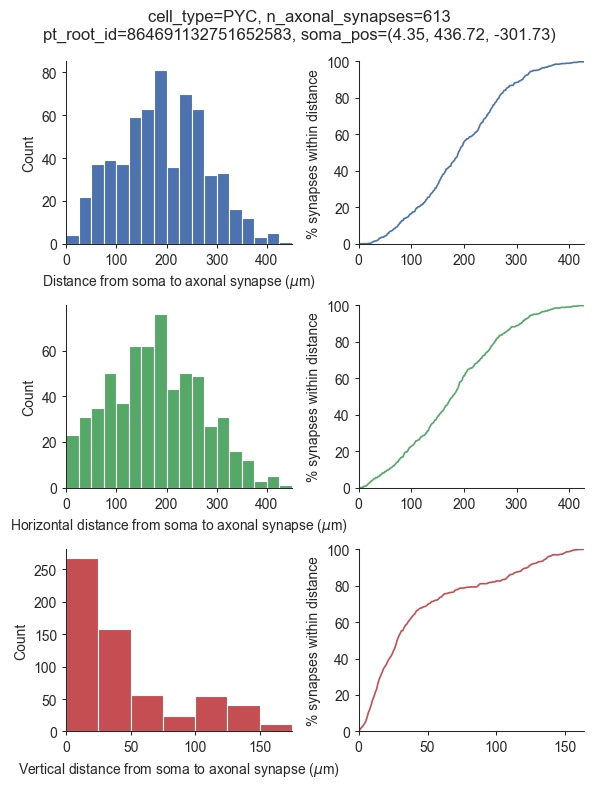

In [566]:
# Fetch the axonal synapses
synapses = client.materialize.synapse_query(pre_ids=pt_root_id)
synapses["syn_position_microns"] = synapses["pre_pt_position"].apply(lambda pos: transform_position_to_microns(pos, df=synapses))

synaptic_distances = synapses.syn_position_microns.apply(lambda syn_pos: np.sqrt(sum((syn_pos[i] - soma_pos[i]) ** 2 for i in [0, 1, 2])))
synaptic_distances_horiz = synapses.syn_position_microns.apply(lambda syn_pos: np.sqrt(sum((syn_pos[i] - soma_pos[i]) ** 2 for i in [0, 2])))
synaptic_distances_vert = synapses.syn_position_microns.apply(lambda syn_pos: abs(syn_pos[1] - soma_pos[1]))

fig, axs = plt.subplots(figsize=(6, 8), nrows=3, ncols=2)
soma_pos_str = ", ".join([f"{x:.2f}" for x in soma_pos])
fig.suptitle(f"cell_type={cell_type}, n_axonal_synapses={len(synapses)}\npt_root_id={pt_root_id}, soma_pos=({soma_pos_str})")

for i, (d, name, color) in enumerate([(synaptic_distances, "Distance", "b"), (synaptic_distances_horiz, "Horizontal distance", "g"), (synaptic_distances_vert, "Vertical distance", "r")]):
    ax = axs[i, 0]
    bins = np.arange(0, d.max()+25, 25)
    ax.hist(d, bins=bins, color=color)
    ax.set_xlabel(f"{name} from soma to axonal synapse ($\mu$m)")
    ax.set_ylabel("Count")
    ax.set_xlim(bins.min(), bins.max())

    ax = axs[i, 1]
    dist_to_synapse = np.arange(0, d.max()+1, 1)
    pct_synapses_within_dist = np.mean(np.expand_dims(d, axis=1) < dist_to_synapse, axis=0) * 100
    ax.plot(dist_to_synapse, pct_synapses_within_dist, color=color)
    # ax.set_xlabel(f"{name} from soma to axonal synapse ($\mu$m)")
    ax.set_ylabel("% synapses within distance")
    ax.set_xlim(0, dist_to_synapse.max())
    ax.set_ylim(0, 100)

fig.tight_layout()

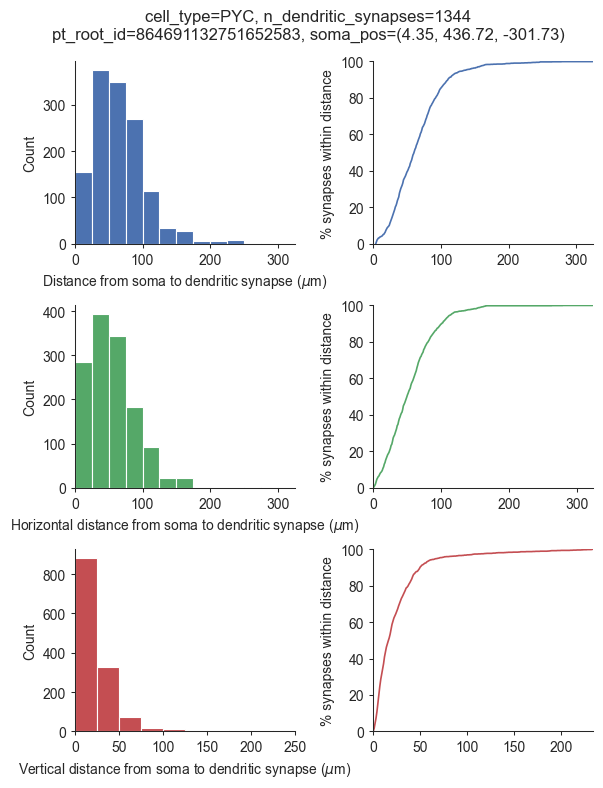

In [567]:
# Do the same for dendritic synapses
synapses = client.materialize.synapse_query(post_ids=pt_root_id)
synapses["syn_position_microns"] = synapses["post_pt_position"].apply(lambda pos: transform_position_to_microns(pos, df=synapses))
synaptic_distances = synapses.syn_position_microns.apply(lambda syn_pos: np.sqrt(sum((syn_pos[i] - soma_pos[i]) ** 2 for i in [0, 1, 2])))
synaptic_distances_horiz = synapses.syn_position_microns.apply(lambda syn_pos: np.sqrt(sum((syn_pos[i] - soma_pos[i]) ** 2 for i in [0, 2])))
synaptic_distances_vert = synapses.syn_position_microns.apply(lambda syn_pos: abs(syn_pos[1] - soma_pos[1]))

fig, axs = plt.subplots(figsize=(6, 8), nrows=3, ncols=2)
soma_pos_str = ", ".join([f"{x:.2f}" for x in soma_pos])
fig.suptitle(f"cell_type={cell_type}, n_dendritic_synapses={len(synapses)}\npt_root_id={pt_root_id}, soma_pos=({soma_pos_str})")

for i, (d, name, color) in enumerate([(synaptic_distances, "Distance", "b"), (synaptic_distances_horiz, "Horizontal distance", "g"), (synaptic_distances_vert, "Vertical distance", "r")]):
    ax = axs[i, 0]
    bins = np.arange(0, d.max()+25, 25)
    ax.hist(d, bins=bins, color=color)
    ax.set_xlabel(f"{name} from soma to dendritic synapse ($\mu$m)")
    ax.set_ylabel("Count")
    ax.set_xlim(bins.min(), bins.max())

    ax = axs[i, 1]
    dist_to_synapse = np.arange(d.min(), d.max()+1, 1)
    pct_synapses_within_dist = np.mean(np.expand_dims(d, axis=1) < dist_to_synapse, axis=0) * 100
    ax.plot(dist_to_synapse, pct_synapses_within_dist, color=color)
    # ax.set_xlabel(f"{name} from soma to dendritic synapse ($\mu$m)")
    ax.set_ylabel("% synapses within distance")
    ax.set_xlim(0, dist_to_synapse.max())
    ax.set_ylim(0, 100)

fig.tight_layout()

In [561]:
print(make_neuron_neuroglancer_link(client, pt_root_id, show_inputs=False, show_outputs=True).data)

<a href="https://neuromancer-seung-import.appspot.com/?json_url=https://globalv1.em.brain.allentech.org/nglstate/api/v1/5330391175004160">Neuroglancer Link</a>


In [647]:
cell_type_table.cell_type.unique()

array(['PYC', 'Non-neuronal', 'BC', 'MC', 'BPC', 'Unsure I', 'NGC'],
      dtype=object)

### Repeat the above procedure except averaging across many cells

In [658]:
pt_root_id_typed_axons = axon_proofreading.pt_root_id[(axon_proofreading.cell_type.isin(done_cell_type)) & (axon_proofreading.pt_root_id.isin(cell_type_table.pt_root_id))].values

# Choose random cells of a certain type
# cell_type = "PYC"
# cell_type = "MC"
cell_type = "BC"
# cell_type = "BPC"
n_cells = 50
pt_root_ids_of_type = [id for id in pt_root_id_typed_axons if cell_type_table.cell_type[cell_type_table.pt_root_id == id].iloc[0] == cell_type]
if n_cells > len(pt_root_ids_of_type):
    print(f"Tried to select {n_cells} of type {cell_type} but ony {len(pt_root_ids_of_type)} cells available")
    n_cells =  len(pt_root_ids_of_type)
pt_root_ids = np.random.choice(pt_root_ids_of_type, size=n_cells, replace=False)

# Load all pre-/postsynaptic synapses for the relevant cells
all_dendritic_synapses = client.materialize.synapse_query(post_ids=pt_root_ids)
all_axonal_synapses = client.materialize.synapse_query(pre_ids=pt_root_ids)

# Load soma positions
# soma_table = client.materialize.query_table("nucleus_detection_v0", filter_in_dict=dict(pt_root_id=pt_root_ids))
soma_table = client.materialize.query_table("nucleus_detection_v0", filter_in_dict=dict(pt_root_id=np.unique(np.concatenate((pt_root_ids, all_dendritic_synapses.pre_pt_root_id, all_axonal_synapses.post_pt_root_id)))))

# Compute synaptic positions (microns)
all_dendritic_synapses["syn_position_microns"] = all_dendritic_synapses["post_pt_position"].apply(lambda pos: transform_position_to_microns(pos, df=all_dendritic_synapses))
all_axonal_synapses["syn_position_microns"] = all_axonal_synapses["pre_pt_position"].apply(lambda pos: transform_position_to_microns(pos, df=all_axonal_synapses))

# Compute pre-/postsynaptic somata positions (microns)
def f(row, key):
    pt_root_id = row[key]
    presyn_soma_pos = soma_table.pt_position[soma_table.pt_root_id == pt_root_id].values
    if len(presyn_soma_pos) == 0:
        return None
    return transform_position_to_microns(presyn_soma_pos[0], df=soma_table)
all_dendritic_synapses["presyn_soma_position_microns"] = all_dendritic_synapses.apply(lambda row: f(row, "pre_pt_root_id"), axis=1)
all_axonal_synapses["postsyn_soma_position_microns"] = all_dendritic_synapses.apply(lambda row: f(row, "post_pt_root_id"), axis=1)

Tried to select 50 of type BC but ony 21 cells available


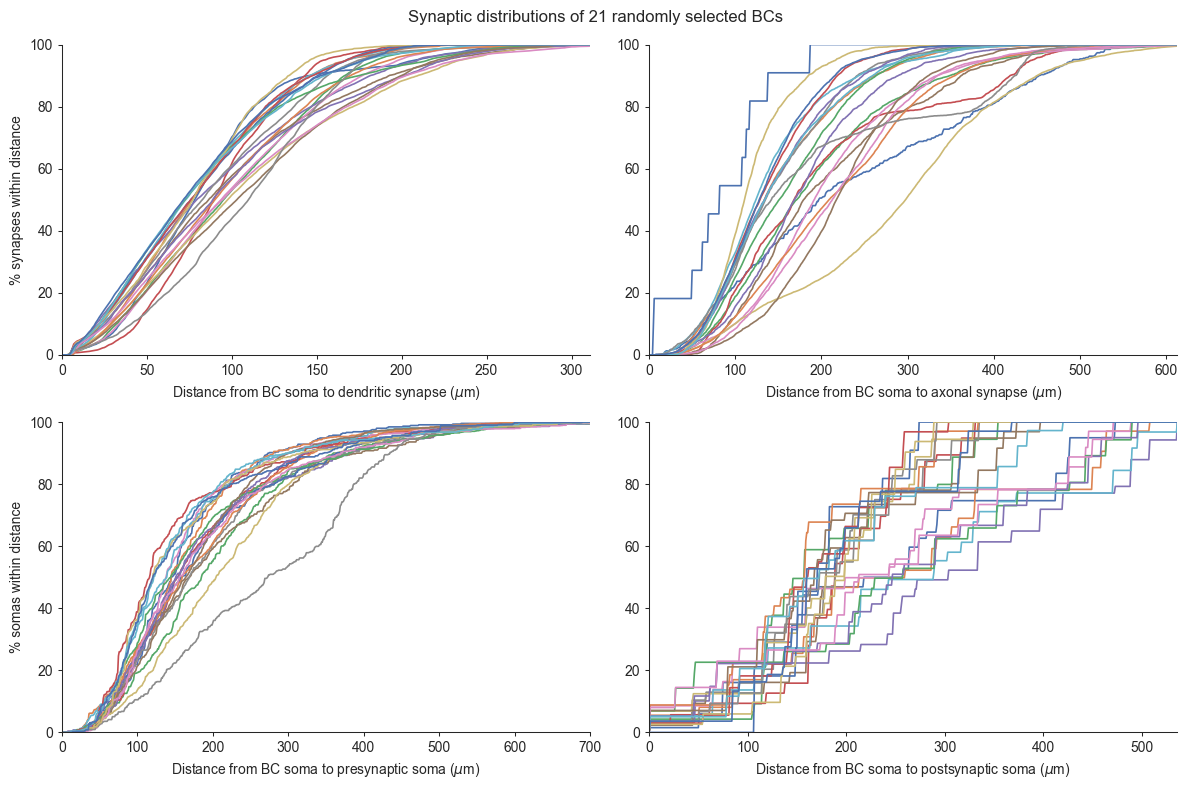

In [659]:
dist = np.arange(0, 1001, 1)
pct_dendritic_syn_within_dist = np.empty((n_cells, len(dist)))
pct_axonal_syn_within_dist = np.empty((n_cells, len(dist)))
pct_presyn_soma_within_dist = np.empty((n_cells, len(dist)))
pct_postsyn_soma_within_dist = np.empty((n_cells, len(dist)))
d = np.empty((n_cells, len(dist)))

for i, pt_root_id in enumerate(pt_root_ids):
    soma_pos = transform_position_to_microns(soma_table.pt_position[soma_table.pt_root_id == pt_root_id].values[0], df=soma_table)
    dendritic_synapses = all_dendritic_synapses[all_dendritic_synapses.post_pt_root_id == pt_root_id]
    axonal_synapses = all_axonal_synapses[all_axonal_synapses.pre_pt_root_id == pt_root_id]


    def euclidean_dist_to_soma(pos):
        if np.any(pd.isna(pos)):
            return np.nan
        return np.sqrt(sum((pos[i] - soma_pos[i]) ** 2 for i in [0, 1, 2]))
    dendritic_syn_dist = dendritic_synapses.syn_position_microns.apply(euclidean_dist_to_soma)
    axonal_syn_dist = axonal_synapses.syn_position_microns.apply(euclidean_dist_to_soma)
    presyn_soma_dist = dendritic_synapses.presyn_soma_position_microns.dropna().apply(euclidean_dist_to_soma)
    postsyn_soma_dist = axonal_synapses.postsyn_soma_position_microns.dropna().apply(euclidean_dist_to_soma)

    # TODO: Investigate horizontal and vertical distances?
    # synaptic_distances_horiz = synapses.syn_position_microns.apply(lambda syn_pos: np.sqrt(sum((syn_pos[i] - soma_pos[i]) ** 2 for i in [0, 2])))
    # synaptic_distances_vert = synapses.syn_position_microns.apply(lambda syn_pos: syn_pos[1] - soma_pos[1])

    pct_dendritic_syn_within_dist[i, :] = np.mean(np.expand_dims(dendritic_syn_dist, axis=1) < dist, axis=0) * 100
    pct_axonal_syn_within_dist[i, :] = np.mean(np.expand_dims(axonal_syn_dist, axis=1) < dist, axis=0) * 100
    pct_presyn_soma_within_dist[i, :] = np.mean(np.expand_dims(presyn_soma_dist, axis=1) < dist, axis=0) * 100
    pct_postsyn_soma_within_dist[i, :] = np.mean(np.expand_dims(postsyn_soma_dist, axis=1) < dist, axis=0) * 100

fig, axs = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
fig.suptitle(f"Synaptic distributions of {n_cells} randomly selected {cell_type}s")

for ax_coords, name, d in (((0, 0), "dendritic synapse", pct_dendritic_syn_within_dist), ((0, 1), "axonal synapse", pct_axonal_syn_within_dist), ((1, 0), "presynaptic soma", pct_presyn_soma_within_dist), ((1, 1), "postsynaptic soma", pct_postsyn_soma_within_dist)):
    ax = axs[ax_coords]

    for j in range(len(d)):
        ax.plot(dist, d[j])
    # ax.plot(d.T) # Same as above

    ax.set_xlabel(f"Distance from {cell_type} soma to {name} ($\mu$m)")

    # Cut of plots when all lines go above almost 100%
    m = np.where(d.min(axis=0) >= 99.5)[0]
    m = m[0] if len(m) > 0 else dist.max()
    ax.set_xlim(0, m)
    ax.set_ylim(0, 100)
    if ax_coords[1] == 0:
        ax.set_ylabel(f"% {name.split(' ')[1]}s within distance")

fig.tight_layout()

### Find correspondance between EM cells and 2P ROIs
The `correspondance_pilot` table contains these mappings

In [45]:
client.materialize.get_table_metadata("correspondance_pilot")

{'valid': True,
 'table_name': 'correspondance_pilot',
 'created': '2022-08-30T20:40:44.103803',
 'id': 2059,
 'aligned_volume': 'v1dd',
 'schema': 'cell_type_local',
 'schema_type': 'cell_type_local',
 'user_id': '5',
 'notice_text': None,
 'flat_segmentation_source': None,
 'write_permission': 'PRIVATE',
 'last_modified': '2022-11-02T20:54:30.347783',
 'description': 'Pilot correspondance locations between functional and structural data, done manually.',
 'reference_table': None,
 'read_permission': 'PUBLIC',
 'voxel_resolution': [9.0, 9.0, 45.0]}

In [46]:
def get_corresponding_col_vol_plane_roi_by_row(row):
    cls_sys = row["classification_system"] # e.g., "session13"
    cell_type = row["cell_type"] # e.g., "plane2_roi_0269"
    col = int(cls_sys[-2])
    vol = cls_sys[-1]
    try: vol = int(vol)
    except: pass
    try:
        if "," in cell_type: # Means the cell was recorded twice in 2P
            # Choose the first one
            cell_type = cell_type[:cell_type.find(",")]

        split = cell_type.split("_")
        if len(split) == 2:
            plane, roi = split
        elif len(split) == 3:
            plane, _, roi = split
        plane = int(plane[5:]) + 1 # IMPORTANT! The plane here is zero-indexed
        roi = int(roi)
        return col, vol, plane, roi
    except:
        print("Bad cell type:", cell_type)
        return None

def get_corresponding_col_vol_plane_roi(correspondance_table, id):
    rows = correspondance_table[correspondance_table.id == id]
    if len(rows) == 0:
        return None
    row = rows.iloc[0]
    return get_corresponding_col_vol_plane_roi_by_row(row)

In [47]:
correspondance_table = client.materialize.query_table("correspondance_pilot")
correspondance_table.drop_duplicates("pt_root_id", inplace=True)
correspondance_table["roi_lookup"] = correspondance_table.apply(lambda row: "-".join(map(str, get_corresponding_col_vol_plane_roi_by_row(row))), axis=1)
correspondance_table = correspondance_table[["roi_lookup", "pt_root_id", "pt_supervoxel_id"]]

# Merge with soma table
soma_table = client.materialize.query_table("nucleus_detection_v0", filter_in_dict=dict(pt_root_id=correspondance_table.pt_root_id.values))
soma_table["soma_position_microns"] = soma_table.pt_position.apply(lambda pos: transform_position_to_microns(pos, df=soma_table))
soma_table = soma_table[["pt_root_id", "volume", "soma_position_microns"]]
correspondance_table = correspondance_table.merge(soma_table, how="inner", on="pt_root_id")

print(f"There are {len(correspondance_table)} EM-2P corresponded ROIs")
correspondance_table

There are 48 EM-2P corresponded ROIs


,roi_lookup,pt_root_id,pt_supervoxel_id,volume,soma_position_microns
0,1-3-3-32,864691132724503921,92618530666908453,203.224374,"[-91.73418502569432, 372.108793104062, -413.11..."
1,1-3-3-269,864691132807412738,93109944114777440,335.971664,"[-74.19141538234277, 373.0233438254795, -248.6..."
2,1-3-3-158,864691132594653239,95150912506684625,324.422531,"[-1.3182978196516633, 374.2718784722247, -274...."
3,1-3-3-230,864691133065754585,94658606108307469,312.839525,"[-18.91283549329883, 378.4265091896778, -296.0..."
4,1-3-2-30,864691132730137072,91843650048621008,313.577943,"[-120.275786757953, 359.60326492832405, -335.4..."
5,1-3-4-14,864691132972662837,92619149142268068,261.082227,"[-91.08408243436983, 393.6238729665716, -417.4..."
6,1-3-1-117,864691132720379604,91491600034985757,377.762618,"[-131.5503736413403, 339.42362049452265, -381...."
7,1-3-2-5,864691132951373898,92055305902526108,306.953857,"[-112.49066409693508, 364.63098169886706, -393..."
8,1-3-3-83,864691132668474560,90999225252445787,193.374551,"[-149.8625784557918, 370.96903799167126, -301...."
9,1-3-3-25,864691132835126165,94235843954739595,342.765655,"[-35.24621969533723, 370.9567484414983, -261.7..."


In [433]:
correspondance_table.merge(axon_proofreading.drop_duplicates("pt_root_id"), how="inner", on="pt_root_id").cell_type.value_counts()

submitted    24
given        14
clean         6
withdrawn     3
complete      1
Name: cell_type, dtype: int64

In [434]:
correspondance_table.merge(dendrite_proofreading.drop_duplicates("pt_root_id"), how="inner", on="pt_root_id").cell_type.value_counts()

submitted      20
in_progress     4
Name: cell_type, dtype: int64

### Load metrics of EM-2P corresponded cells

In [54]:
metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/v1dd-chase/dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)
metrics = metrics[metrics.is_valid & (metrics.mouse == 409828)] # We only care about this mouse
metrics.insert(5, "roi_lookup", metrics.apply(lambda row: f"{row.column}-{row.volume}-{row.plane}-{row.roi}", axis=1))
metrics.head()

,mouse,column,volume,plane,roi,roi_lookup,is_valid,depth,dgf_pref_response,dgf_pref_dir,...,dgw_null_dist_single_std,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std
M409828_11_1_89,409828,1,1,1,89,1-1-1-89,True,50,0.000943,330.0,...,0.000450,0.000710,0.000586,0.265065,0.419054,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903
M409828_11_2_0,409828,1,1,2,0,1-1-2-0,True,66,0.000919,270.0,...,0.000653,0.000394,0.000911,-0.084075,-0.183585,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629
M409828_11_2_1,409828,1,1,2,1,1-1-2-1,True,66,0.011217,0.0,...,0.000538,0.002046,0.009295,-0.065169,-0.139425,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262
M409828_11_2_2,409828,1,1,2,2,1-1-2-2,True,66,0.001237,120.0,...,0.000582,0.000344,0.000369,0.536319,0.698187,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412
M409828_11_2_4,409828,1,1,2,4,1-1-2-4,True,66,0.001093,240.0,...,0.000381,0.000221,0.000660,-0.034136,-0.070685,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601


In [55]:
# Merge with metrics
# metrics.reset_index() makes the metrics index (e.g., "M409828_11_1_89") into an "index" column, that is then renamed to "metrics_index"
metrics_corresponded = correspondance_table.merge(metrics.reset_index().rename(dict(index="metrics_index"), axis=1), how="inner", on="roi_lookup")

print(f"{len(metrics_corresponded)}/{len(correspondance_table)} corresponded cells have computed metrics")
metrics_corresponded.head()

48/48 corresponded cells have computed metrics


,roi_lookup,pt_root_id,pt_supervoxel_id,volume_x,soma_position_microns,metrics_index,mouse,column,volume_y,plane,...,dgw_null_dist_single_std,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std
0,1-3-3-32,864691132724503921,92618530666908453,203.224374,"[-91.73418502569432, 372.108793104062, -413.11...",M409828_13_3_32,409828,1,3,3,...,0.002111,0.018674,0.033937,-0.290118,-0.817369,-0.290118,0.194248,"[-2.4632645, -0.817369, 0.7327993, 0.5054022, ...",0.000799,0.005814
1,1-3-3-269,864691132807412738,93109944114777440,335.971664,"[-74.19141538234277, 373.0233438254795, -248.6...",M409828_13_3_269,409828,1,3,3,...,0.000861,0.000671,0.000817,0.280874,0.438567,-0.634099,1.000000,"[-2.1400816, 0.43856665, -0.26676092, -8.6836,...",0.000485,0.003471
2,1-3-3-158,864691132594653239,95150912506684625,324.422531,"[-1.3182978196516633, 374.2718784722247, -274....",M409828_13_3_158,409828,1,3,3,...,0.000915,0.000292,0.001247,0.869840,0.930390,0.857814,0.456243,"[0.6363017, 0.9099539, 0.89161897, 0.099112436...",0.000440,0.003577
3,1-3-3-230,864691133065754585,94658606108307469,312.839525,"[-18.91283549329883, 378.4265091896778, -296.0...",M409828_13_3_230,409828,1,3,3,...,0.000931,0.000965,0.000931,0.278931,0.436194,0.269550,-0.038943,"[-0.06488019, 1.0, 1.0, 0.43619362, 1.0, 0.613...",0.000552,0.003833
4,1-3-2-30,864691132730137072,91843650048621008,313.577943,"[-120.275786757953, 359.60326492832405, -335.4...",M409828_13_2_30,409828,1,3,2,...,0.002585,0.022880,0.001381,0.928388,0.962865,0.615817,-0.044903,"[-0.71139765, 0.012657457, 0.6854488, 0.667537...",0.000804,0.007169


Get a list of ROIs that have been EM-2P corresponded

In [56]:
print(", ".join(x[4:] for x in metrics_corresponded.roi_lookup.sort_values().values))

1-117, 1-209, 1-40, 1-60, 1-65, 1-67, 1-671, 1-88, 2-145, 2-26, 2-262, 2-271, 2-30, 2-5, 2-667, 2-75, 3-139, 3-14, 3-158, 3-161, 3-191, 3-215, 3-230, 3-237, 3-25, 3-250, 3-265, 3-269, 3-29, 3-294, 3-300, 3-32, 3-4, 3-414, 3-74, 3-83, 4-14, 4-187, 4-212, 4-306, 4-387, 4-89, 4-98, 5-109, 5-119, 5-17, 5-419, 6-470


### Visualize the EM-2P corresponded cells

<AxesSubplot:xlabel='pt_position_x', ylabel='pt_position_z'>

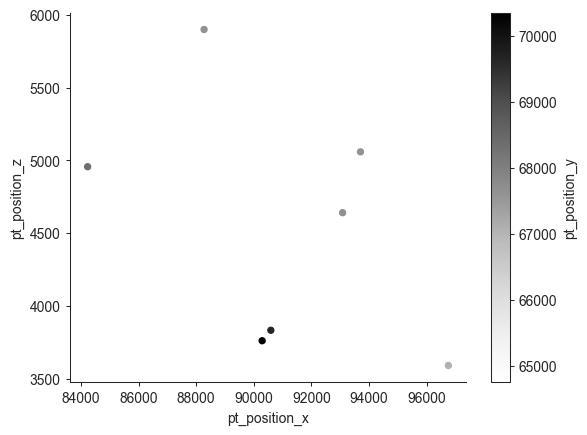

In [52]:
proofread_axons[proofread_axons.pt_root_id.isin(correspondance_table.pt_root_id)].plot(kind="scatter", x="pt_position_x", y="pt_position_z", c="pt_position_y")

In [53]:
responsive_dgw = metrics_corresponded.dgw_frac_responsive_trials >= 0.5
responsive_dgf = metrics_corresponded.dgf_frac_responsive_trials >= 0.5
metrics_corresponded["responsive_dgw"] = responsive_dgw
metrics_corresponded["responsive_dgf"] = responsive_dgf

print(f"{responsive_dgw.sum()}/{len(responsive_dgw)} responsive DGW")
print(f"{responsive_dgf.sum()}/{len(responsive_dgf)} responsive DGF")

NameError: name 'metrics_corresponded' is not defined

Text(0, 0.5, 'ROI count')

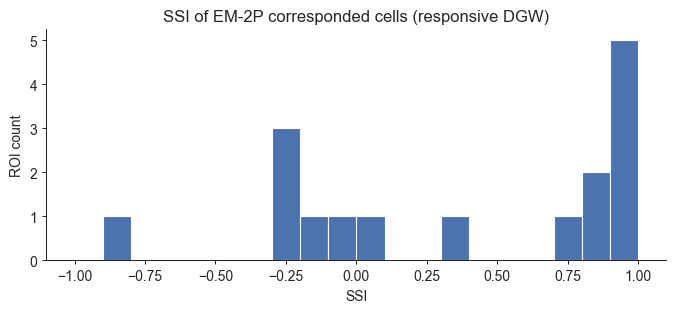

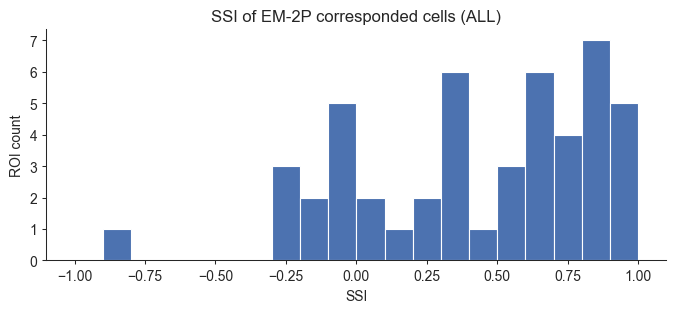

In [446]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(metrics_corresponded.ssi[responsive_dgw], bins=np.arange(-1, 1.1, 0.1))
ax.set_title("SSI of EM-2P corresponded cells (responsive DGW)")
ax.set_xlabel("SSI")
ax.set_ylabel("ROI count")

fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(metrics_corresponded.ssi, bins=np.arange(-1, 1.1, 0.1))
ax.set_title("SSI of EM-2P corresponded cells (ALL)")
ax.set_xlabel("SSI")
ax.set_ylabel("ROI count")

In [447]:
metrics_corresponded[responsive_dgw][["pt_root_id", "roi_lookup", "ssi"]].sort_values("ssi", ascending=False)

,pt_root_id,roi_lookup,ssi
9,864691132835126165,1-3-3-25,0.975883
4,864691132730137072,1-3-2-30,0.928388
27,864691132734110231,1-3-4-212,0.918396
42,864691132885716143,1-3-3-161,0.904732
20,864691132958399079,1-3-4-98,0.902916
2,864691132594653239,1-3-3-158,0.869840
23,864691132834400136,1-3-5-17,0.816951
38,864691132671714517,1-3-5-109,0.707162
29,864691132833646702,1-3-2-271,0.323559
13,864691132924264745,1-3-2-26,0.022000


In [111]:
import sys
if ".." not in sys.path: sys.path.insert(0, "..")

from experiment.v1dd_client import V1DDClient
from stimulus_analysis.drifting_gratings import DriftingGratings

v1dd_client = V1DDClient("/Users/chase/Desktop/test_v1dd_data")
session = v1dd_client.load_ophys_session(mouse=409828, column=1, volume=3)
dg = {}

for plane in session.get_planes():
    dgw = DriftingGratings(session, plane, dg_type="windowed")
    dgf = DriftingGratings(session, plane, dg_type="full")
    dg[plane] = (dgw, dgf)

Loading DG-full response metrics for session M409828_13, plane 3...
Loading DG-windowed response metrics for session M409828_13, plane 3...
Loading DG-full response metrics for session M409828_13, plane 2...
Loading DG-windowed response metrics for session M409828_13, plane 2...


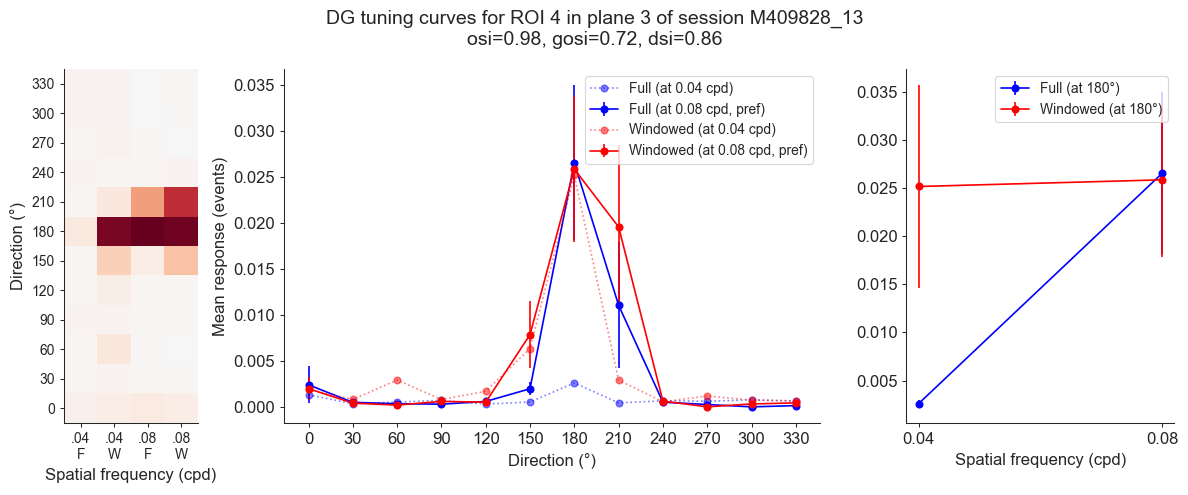

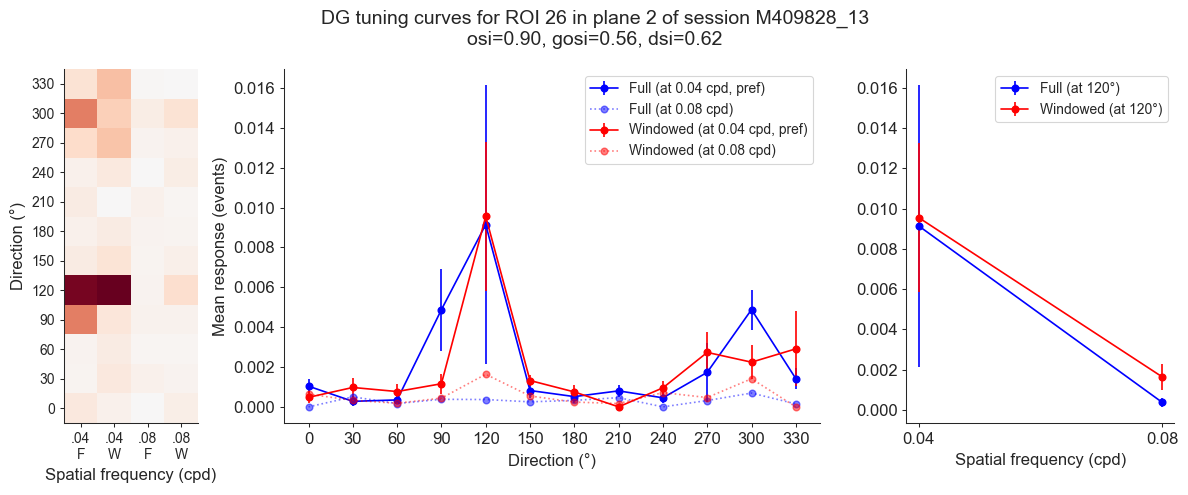

In [112]:
def dg_analyze(plane, roi):
    dg[plane][0].plot_roi_tuning_curves(roi=roi, dg_other=dg[plane][1], plot_all_sf=True)

# dg_analyze(3, 29)
# dg_analyze(3, 25)
# dg_analyze(4, 212)
# dg_analyze(3, 161)
# dg_analyze(4, 98)
# dg_analyze(3, 158)

dg_analyze(3, 4)
dg_analyze(2, 26)

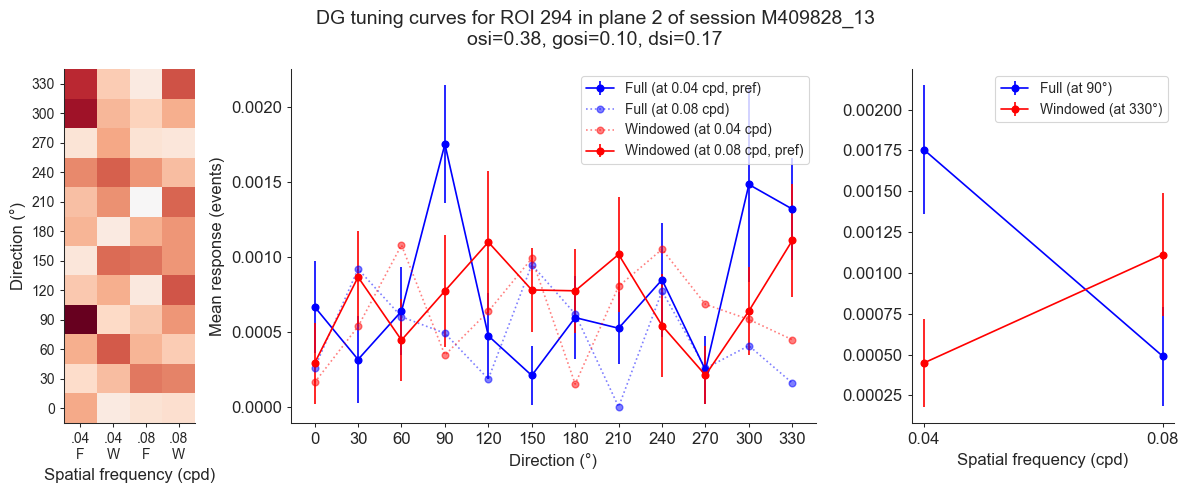

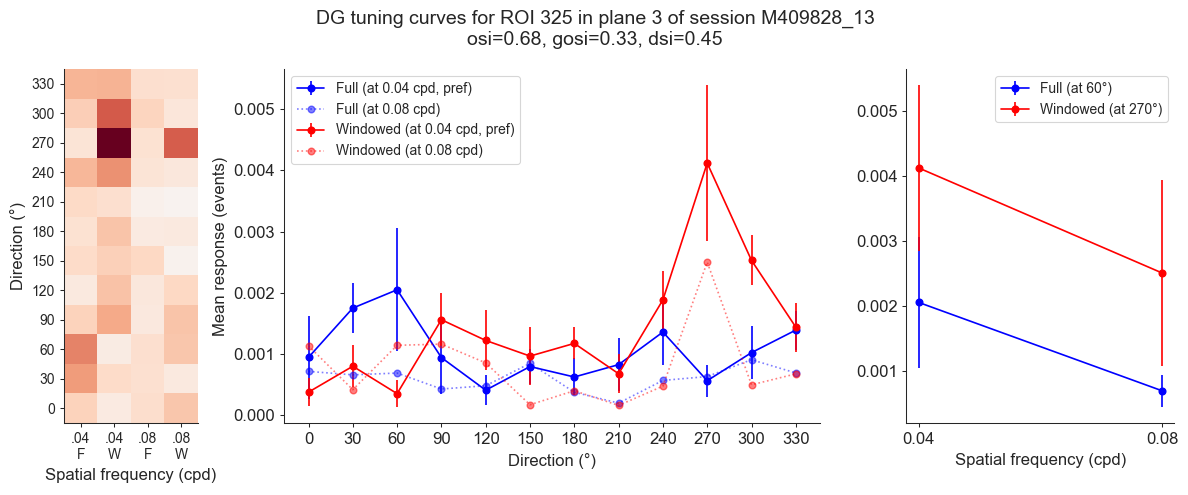

In [113]:
# plane2_294, plane3_0325 are duplicates
dg_analyze(2, 294)
dg_analyze(3, 325)

In [114]:
metrics_corresponded.dgw_pref_dir.value_counts().sort_index()

0.0      6
30.0     7
60.0     2
90.0     5
120.0    4
150.0    7
180.0    3
240.0    5
270.0    2
300.0    4
330.0    3
Name: dgw_pref_dir, dtype: int64

<AxesSubplot:xlabel='dgw_pref_dir', ylabel='count'>

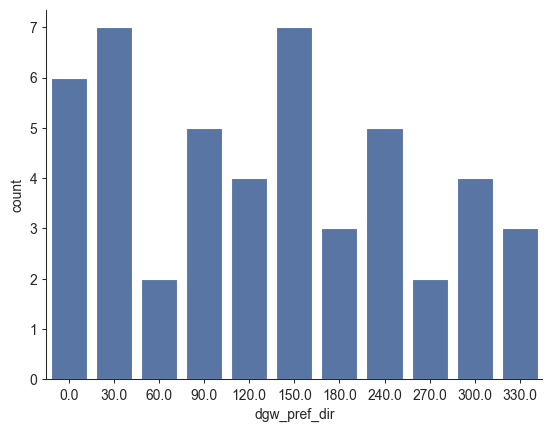

In [115]:
sns.countplot(data=metrics_corresponded, x="dgw_pref_dir", color="b")
# sns.countplot(data=metrics_corresponded, x="dgf_pref_dir", color="b")

In [448]:
root_id = 864691132829082994 # lowest SSI
client.materialize.synapse_query(pre_ids=root_id)

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,287220641,t,88326930961030299,864691132829082994,88326930961030294,864691132607048405,1777,"[68493, 67831, 6603]","[68540, 67849, 6595]","[68536, 67840, 6595]"
1,219912749,t,85649070391563506,864691132829082994,85719439135760483,864691132544485265,159,"[58776, 53548, 6619]","[58813, 53585, 6624]","[58814, 53566, 6621]"
2,558782661,t,99233742576879420,864691132829082994,99233742576883801,864691132827585180,1545,"[108111, 66494, 5478]","[108153, 66452, 5488]","[108140, 66481, 5483]"
3,311799023,t,89454686024936111,864691132829082994,89454686024934973,864691132955355089,1755,"[72569, 74745, 4218]","[72577, 74750, 4212]","[72586, 74764, 4213]"
4,336552036,t,90507812677283895,864691132829082994,90507812677294564,864691132225050741,298,"[76361, 65671, 9556]","[76346, 65702, 9566]","[76365, 65666, 9565]"
...,...,...,...,...,...,...,...,...,...,...
539,490317932,t,96284234116849263,864691132829082994,96284234116859591,864691132856071238,6240,"[97302, 88786, 6710]","[97299, 88808, 6717]","[97287, 88813, 6714]"
540,364208021,t,91422743454844772,864691132829082994,91422812174324738,864691132801476317,1582,"[79654, 66409, 6885]","[79616, 66439, 6894]","[79640, 66430, 6888]"
541,373675940,t,91215965811480886,864691132829082994,91215965811477368,864691133119265893,380,"[78785, 82423, 1486]","[78807, 82420, 1483]","[78788, 82422, 1484]"
542,309667663,t,89379644826036367,864691132829082994,89379644826023033,864691132729064832,480,"[72180, 57389, 7746]","[72195, 57345, 7738]","[72208, 57354, 7739]"


In [449]:
client.materialize.synapse_query(post_ids=root_id)

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,297065866,t,88888644164867572,864691132751204741,88888644164886011,864691132829082994,1111,"[70447, 63134, 7844]","[70456, 63179, 7855]","[70435, 63157, 7855]"
1,349098823,t,91069181478615113,864691132723981567,91069181478627303,864691132829082994,435,"[78272, 59954, 4856]","[78302, 60008, 4864]","[78290, 59982, 4860]"
2,344019059,t,90155143853104513,864691132361668661,90155143853087863,864691132829082994,445,"[74983, 62629, 6159]","[74955, 62596, 6153]","[74986, 62616, 6159]"
3,330288284,t,90014681376307452,864691133000834761,90014681376303309,864691132829082994,2593,"[74533, 63753, 6702]","[74562, 63779, 6699]","[74565, 63744, 6704]"
4,368381901,t,91351481290262960,864691132035278159,91351481290270969,864691132829082994,4899,"[79412, 62862, 6309]","[79419, 62881, 6318]","[79420, 62895, 6310]"
...,...,...,...,...,...,...,...,...,...,...
3155,298129058,t,88677469011653520,864691131907391291,88677469011660347,864691132829082994,1227,"[69790, 62875, 6408]","[69793, 62856, 6413]","[69806, 62871, 6411]"
3156,374895030,t,91984937292554439,864691132531199013,91984937292564924,864691132829082994,5829,"[81713, 63410, 5229]","[81765, 63426, 5238]","[81743, 63442, 5233]"
3157,254403240,t,86918113035208322,864691132356959842,86918113035194455,864691132829082994,1215,"[63355, 62481, 6787]","[63341, 62546, 6772]","[63348, 62507, 6781]"
3158,309678254,t,89311680928532957,864691133218868048,89382049672720264,864691132829082994,967,"[72117, 66411, 5642]","[72157, 66404, 5644]","[72119, 66405, 5637]"


In [80]:
print(make_neuron_neuroglancer_link(client, root_id, show_inputs=True, show_outputs=True).data)

<a href="https://neuromancer-seung-import.appspot.com/?json_url=https://globalv1.em.brain.allentech.org/nglstate/api/v1/4858305549697024">Neuroglancer Link</a>


In [84]:
# do the same, but for the highest SSI cell
root_id = 864691132835126165
print(make_neuron_neuroglancer_link(client, root_id, show_inputs=True, show_outputs=True).data)
client.materialize.synapse_query(pre_ids=root_id)

<a href="https://neuromancer-seung-import.appspot.com/?json_url=https://globalv1.em.brain.allentech.org/nglstate/api/v1/5899033302269952">Neuroglancer Link</a>


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,460675912,t,95151737073081932,864691132835126165,95151737073057682,864691132447788917,581,"[904.4182999999998, 623.4868999999999, 277.335]","[904.6898999999999, 623.1667999999999, 277.289...","[904.6122999999999, 623.3802, 277.245]"
1,610404120,t,101421221295556289,864691132835126165,101421221295553967,864691132783709778,508,"[1126.6549999999997, 863.7073999999999, 349.46...","[1126.5191999999997, 863.6782999999999, 349.28...","[1126.5676999999998, 863.6685999999999, 349.28..."
2,243293047,t,86501123116421961,864691132835126165,86501123116417259,864691130487883385,1110,"[599.5860999999999, 794.3523999999999, 268.784...","[599.1496, 794.4299999999998, 268.605]","[599.3532999999999, 794.2553999999999, 268.695]"
3,539852989,t,98882724026525521,864691132835126165,98882724026535197,864691132596383807,897,"[1034.8929999999998, 676.2548999999999, 428.625]","[1035.1743, 676.2160999999999, 429.03]","[1035.1064, 676.0996999999999, 428.895]"
5,525485427,t,98318880585769165,864691132835126165,98318880585786250,864691132010169530,1606,"[1015.4444999999998, 642.8965999999999, 385.65]","[1015.0273999999998, 642.5279999999999, 385.91...","[1015.1728999999998, 642.7219999999999, 385.78..."
...,...,...,...,...,...,...,...,...,...,...
544,518812729,t,97757236369294978,864691132835126165,97757236369297543,864691132781260747,2564,"[995.7340999999999, 690.6884999999999, 400.77]","[995.6370999999998, 690.9406999999999, 400.815]","[995.5885999999998, 690.9988999999999, 400.68]"
545,433215299,t,94306556698883648,864691132835126165,94306556698889938,864691132808035465,1562,"[874.5616999999999, 596.7536999999999, 454.77]","[874.5228999999998, 596.5596999999999, 454.995]","[874.6974999999999, 596.5790999999999, 454.95]"
546,397621068,t,92551667153092828,864691132835126165,92551667153091602,864691132668023085,3066,"[811.7444999999999, 752.2737999999999, 363.419...","[812.4234999999999, 752.3901999999999, 363.69]","[812.1130999999999, 752.4192999999999, 363.555]"
547,523476921,t,97484763845371502,864691132835126165,97484763845372941,864691132602063655,2213,"[986.8876999999999, 1015.5026999999999, 471.015]","[987.1689999999999, 1015.4444999999998, 471.06]","[987.2077999999999, 1015.6869999999999, 471.195]"


In [83]:
cell_type_table.cell_type.value_counts()

PYC             3093
Non-neuronal     281
BC               146
Unsure I         102
MC                75
BPC               45
NGC               23
Name: cell_type, dtype: int64

### Get synapses for each of the corresponded cells

In [669]:
pt_root_id_inclusion = pd.Series(data=metrics_corresponded.responsive_dgw.values, index=metrics_corresponded.pt_root_id)
pt_root_id_inclusion.head()

pt_root_id
864691132724503921     True
864691132807412738    False
864691132594653239     True
864691133065754585    False
864691132730137072     True
dtype: bool

In [57]:
print("Loading axonal synapses...", end="")
# pt_root_ids = metrics_corresponded.pt_root_id.values # all cells
# pt_root_ids = metrics_corresponded.pt_root_id[responsive_dgw].values # only DGW-responsive cells
pt_root_ids = metrics_corresponded.pt_root_id.values
axonal_synapses = client.materialize.synapse_query(pre_ids=pt_root_ids)
print(f" Done. {len(axonal_synapses)} total")
print("Loading dendritic synapses...", end="")
dendritic_synapses = client.materialize.synapse_query(post_ids=pt_root_ids)
print(f" Done. {len(dendritic_synapses)} total")

Loading axonal synapses... Done. 19230 total
Loading dendritic synapses... Done. 130561 total


What fraction of corresponded cells have typed dendritic synapses?

,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,1132,t,350562,coarse_manual,PYC,350562,t,326.965400,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]"
1,214,t,383955,coarse_manual,PYC,383955,t,504.192300,95649060060623076,864691132569667100,"[920802, 795478, 329220]","[914826, 790822, 34920]","[926389, 800366, 36123]"
2,13,t,385028,coarse_manual,PYC,385028,t,415.785065,95863052645657911,864691132985016672,"[929338, 898530, 386595]","[924914, 892245, 41162]","[933994, 903885, 42103]"
3,717,t,293764,coarse_manual,PYC,293764,t,231.369357,94450111081742956,864691132625300120,"[878665, 697702, 245475]","[874009, 694365, 26030]","[883554, 701349, 26859]"
4,2604,t,351373,coarse_manual,PYC,351373,t,277.321739,96276193669654108,864691132689074198,"[944314, 572378, 210330]","[939814, 568187, 22179]","[948505, 576413, 23110]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,2460,t,294466,coarse_manual,PYC,294466,t,254.842389,92410998182394371,864691132801576550,"[807118, 754660, 277335]","[801918, 750780, 29464]","[812239, 758540, 30337]"
3761,3145,t,385115,coarse_manual,PYC,385115,t,325.794498,97198684462210065,864691132753189164,"[975354, 850418, 394650]","[970854, 846383, 42079]","[980088, 854764, 42995]"
3762,1609,t,278241,coarse_manual,PYC,278241,t,269.557372,92477243758401406,864691132707099174,"[810377, 605047, 293085]","[806574, 601167, 31103]","[814645, 609005, 32049]"
3763,722,t,383491,coarse_manual,PYC,383491,t,457.329970,95860234945756278,864691132763271347,"[928872, 797418, 316125]","[922897, 793072, 33489]","[934614, 801686, 34774]"


0.06674806674806674

Text(0.5, 0, 'Number of dendritic synapses')

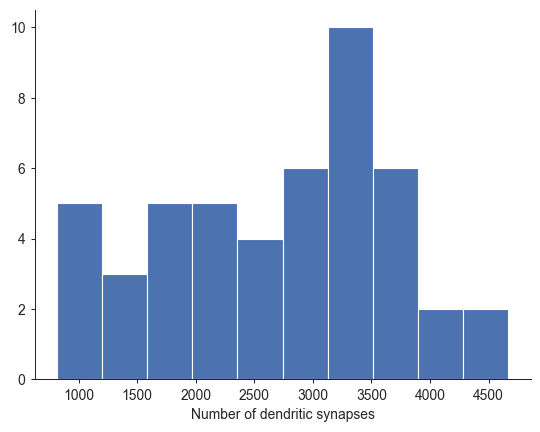

In [74]:
plt.hist([(dendritic_synapses.post_pt_root_id == pt_root_id).sum() for pt_root_id in metrics_corresponded.pt_root_id.values])
plt.xlabel("Number of dendritic synapses")

Text(0.5, 0, 'Number of dendritic synapses with typed cells')

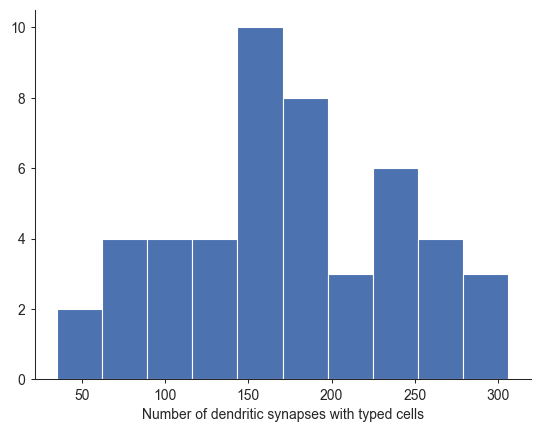

In [75]:
plt.hist([dendritic_synapses.pre_pt_root_id[dendritic_synapses.post_pt_root_id == pt_root_id].isin(cell_type_table.pt_root_id).sum() for pt_root_id in metrics_corresponded.pt_root_id.values])
plt.xlabel("Number of dendritic synapses with typed cells")

Text(0.5, 0, 'Percent of dendritic synapses with typed cells')

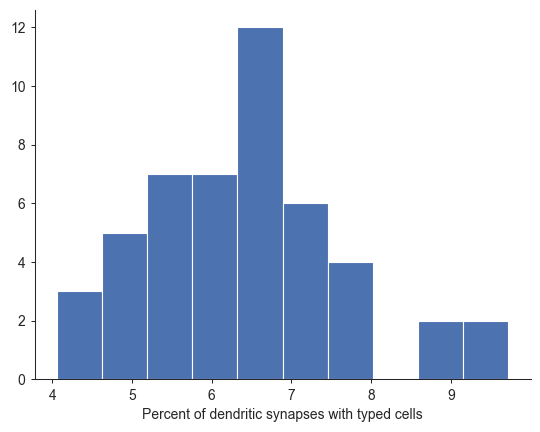

In [77]:
plt.hist([dendritic_synapses.pre_pt_root_id[dendritic_synapses.post_pt_root_id == pt_root_id].isin(cell_type_table.pt_root_id).mean()*100 for pt_root_id in metrics_corresponded.pt_root_id.values])
plt.xlabel("Percent of dendritic synapses with typed cells")

In [90]:
client.materialize.get_table_metadata("nucleus_detection_v0")

{'id': 2068,
 'created': '2022-02-04T06:06:30.673697',
 'aligned_volume': 'v1dd',
 'schema': 'nucleus_detection',
 'valid': True,
 'table_name': 'nucleus_detection_v0',
 'schema_type': 'nucleus_detection',
 'user_id': '3',
 'notice_text': None,
 'flat_segmentation_source': 'precomputed://https://storage.googleapis.com/v1dd_imagery/v1dd_nuclei/segmentation',
 'write_permission': 'PRIVATE',
 'last_modified': '2022-10-27T17:28:14.043442',
 'description': 'This is the first version of nucleus detection from zetta, it includes all nucleus detections larger than 32 um^3. \r\nUploaded by Forrest Collman on Feb 3 2021.\r\n',
 'reference_table': None,
 'read_permission': 'PUBLIC',
 'voxel_resolution': [1.0, 1.0, 1.0]}

In [78]:
soma_table = client.materialize.query_table("nucleus_detection_v0", filter_in_dict=dict(pt_root_id=dendritic_synapses.pre_pt_root_id.values))

In [79]:
soma_table

,id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,366999,t,94.508332,95504886195975688,864691132376695163,"[915990, 671318, 198585]","[912886, 668291, 21112]","[919715, 674732, 21684]"
1,367220,t,35.743240,94659980229571699,864691132456491377,"[886890, 651995, 202770]","[885183, 648891, 21534]","[888675, 654556, 22160]"
2,350792,t,409.260699,95570719387517761,864691132533624410,"[918396, 506650, 172935]","[913818, 501374, 18042]","[923285, 511384, 19133]"
3,275890,t,175.258507,90786400697594328,864691132533674074,"[749616, 534664, 170640]","[745426, 531017, 18027]","[753263, 538234, 18808]"
4,280807,t,358.745569,93601013696900630,864691132533920858,"[850341, 527758, 402030]","[845918, 523645, 42772]","[855385, 531948, 43844]"
...,...,...,...,...,...,...,...,...
6521,365064,t,254.031619,98532459847167861,864691133311785040,"[1022768, 733630, 90900]","[1017957, 730216, 9385]","[1027657, 737122, 10214]"
6522,429084,t,339.746134,101132736999484210,864691133312105808,"[1115190, 610712, 377775]","[1110534, 605978, 40143]","[1120078, 615290, 41283]"
6523,294799,t,247.351982,93252605614192039,864691133312412496,"[838468, 652306, 283590]","[834278, 647727, 30099]","[842736, 656496, 30972]"
6524,218961,t,246.472654,87341424810886612,864691133312698192,"[629258, 646796, 249660]","[625301, 641907, 26389]","[633604, 651762, 27344]"


Text(0.5, 0, 'Percent of dendritic synapses with soma that have been typed')

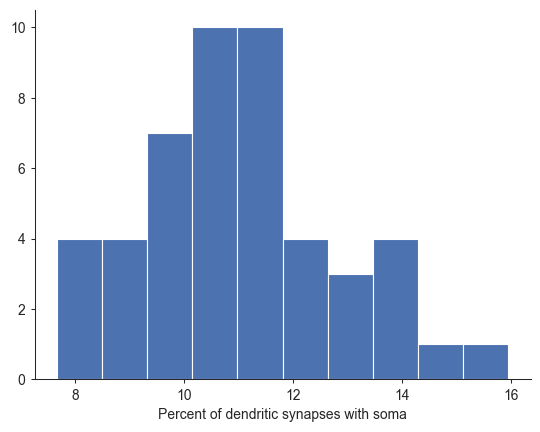

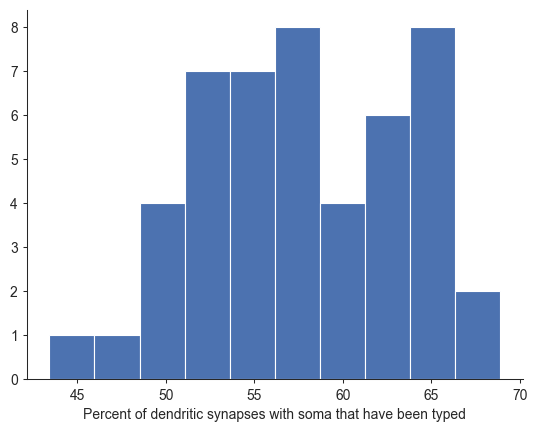

In [88]:
values = []

for pt_root_id in metrics_corresponded.pt_root_id.values:
    pre_pt_root_ids = dendritic_synapses.pre_pt_root_id[dendritic_synapses.post_pt_root_id == pt_root_id]

    values.append(pre_pt_root_ids.isin(soma_table.pt_root_id).mean() * 100)

plt.hist(values)
plt.xlabel("Percent of dendritic synapses with soma")



values = []

for pt_root_id in metrics_corresponded.pt_root_id.values:
    pre_pt_root_ids = dendritic_synapses.pre_pt_root_id[dendritic_synapses.post_pt_root_id == pt_root_id]

    values.append(pre_pt_root_ids[pre_pt_root_ids.isin(soma_table.pt_root_id)].isin(cell_type_table.pt_root_id).mean() * 100)

plt.figure()
plt.hist(values)
plt.xlabel("Percent of dendritic synapses with soma that have been typed")

In [664]:
axonal_synapses["position_microns"] = axonal_synapses["pre_pt_position"].apply(lambda pos: transform_position_to_microns(pos, df=axonal_synapses))
dendritic_synapses["position_microns"] = dendritic_synapses["post_pt_position"].apply(lambda pos: transform_position_to_microns(pos, df=dendritic_synapses))

In [665]:
axonal_synapses.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,position_microns
1,445105384,t,94872255699778575,864691132594653239,94872255699778573,864691131973788562,363,"[92301, 71633, 12105]","[92324, 71658, 12105]","[92326, 71630, 12107]","[-10.93567312001891, 537.008078024496, -72.698..."
2,470963648,t,96136281150812631,864691132594653239,96206649895003002,864691132826613680,1232,"[96953, 61838, 7451]","[96958, 61854, 7455]","[96941, 61833, 7454]","[33.453436902633285, 389.17930463685866, -249...."
3,448415102,t,95008182153272604,864691132594653239,95008182153306578,864691131724608468,127,"[92759, 53804, 6673]","[92753, 53815, 6677]","[92757, 53816, 6677]","[-7.6482592694123746, 304.92529325623275, -261..."
4,419635323,t,93536074059740396,864691132594653239,93536142779225005,864691132608488003,3163,"[87426, 74857, 10949]","[87371, 74883, 10951]","[87392, 74872, 10954]","[-58.14191751616355, 553.4496562539516, -131.1..."
5,419955330,t,93817480317111912,864691132594653239,93887849061293545,864691132051980102,650,"[88498, 74594, 11066]","[88517, 74611, 11062]","[88496, 74608, 11063]","[-47.748866014805394, 552.3492868536, -125.435..."


Plot number of synapses vs. SSI

<AxesSubplot:xlabel='ssi', ylabel='n_axonal'>

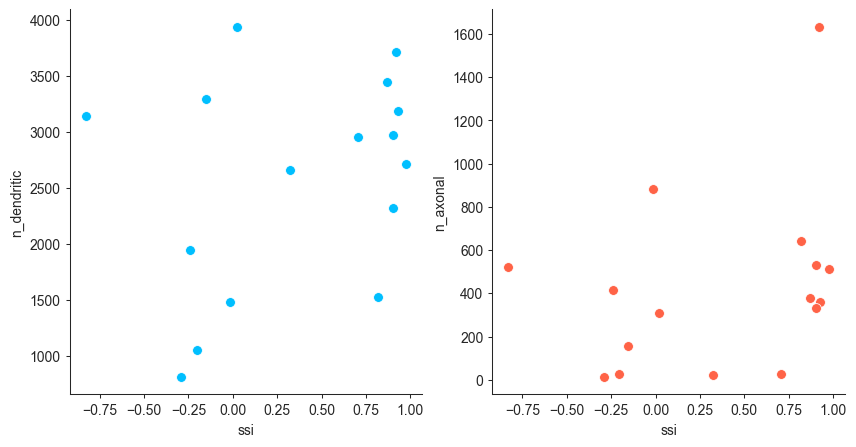

In [670]:
df = pd.DataFrame(index=pt_root_ids)
df["n_axonal"] = axonal_synapses.pre_pt_root_id.value_counts()
df["n_dendritic"] = dendritic_synapses.post_pt_root_id.value_counts()
df["ssi"] = metrics_corresponded[["pt_root_id", "ssi"]].set_index("pt_root_id")

df = df[pt_root_id_inclusion]

fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.scatterplot(data=df, x="ssi", y="n_dendritic", c="deepskyblue", s=50, ax=axs[0])
sns.scatterplot(data=df, x="ssi", y="n_axonal", c="tomato", s=50, ax=axs[1])

Looks like there's no distinct relationship...

How about looking at synaptic strengths?

<AxesSubplot:xlabel='ssi', ylabel='max_dendritic_synapse_size'>

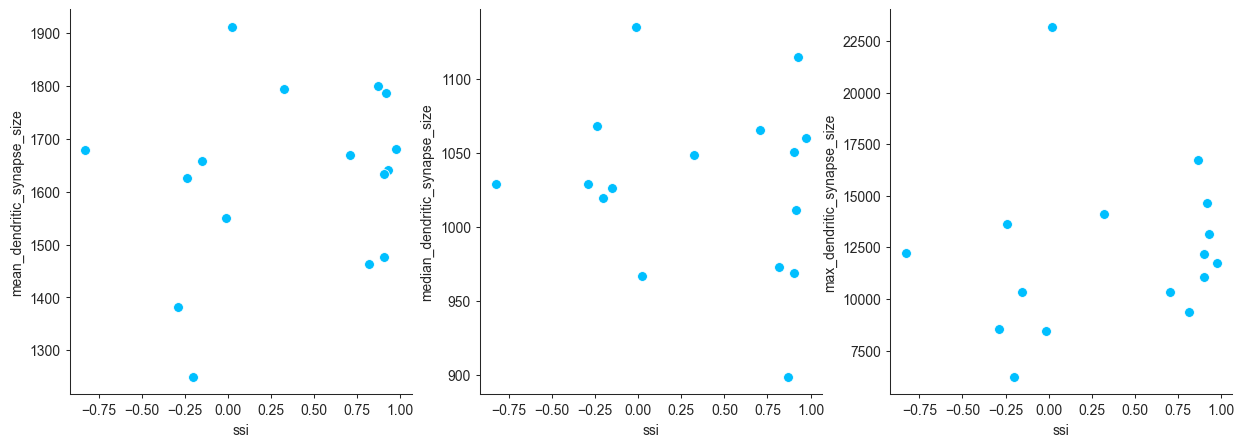

In [671]:
df = pd.DataFrame(index=pt_root_ids)
df["mean_dendritic_synapse_size"] = dendritic_synapses.groupby("post_pt_root_id")["size"].mean()
df["median_dendritic_synapse_size"] = dendritic_synapses.groupby("post_pt_root_id")["size"].median()
df["max_dendritic_synapse_size"] = dendritic_synapses.groupby("post_pt_root_id")["size"].max()
df["ssi"] = metrics_corresponded[["pt_root_id", "ssi"]].set_index("pt_root_id")
df = df[pt_root_id_inclusion]

fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
sns.scatterplot(data=df, x="ssi", y="mean_dendritic_synapse_size", c="deepskyblue", s=50, ax=axs[0])
sns.scatterplot(data=df, x="ssi", y="median_dendritic_synapse_size", c="deepskyblue", s=50, ax=axs[1])
sns.scatterplot(data=df, x="ssi", y="max_dendritic_synapse_size", c="deepskyblue", s=50, ax=axs[2])

Trying out a measurement accounting for synaptic distance...

Each synapse strength is divided by the Euclidean distance to soma.

,center_of_mass_dist_postsyn,mean_syn_dist,max_syn_dist,mean_syn_size,mean_norm_strength,ssi
864691132724503921,49.213301,97.775137,298.238777,1381.264706,27.139119,-0.290118
864691132594653239,14.792775,77.519406,552.436663,1799.564826,32.867082,0.869840
864691132730137072,33.044868,95.482762,315.266056,1641.350580,27.248213,0.928388
864691132972662837,21.508677,90.745932,690.754671,1625.435542,28.514806,-0.240629
864691132835126165,28.111885,86.126457,433.131953,1679.771218,29.579258,0.975883
864691132924264745,27.245490,85.978115,307.851760,1911.320285,33.830052,0.022000
864691132829082994,9.267393,84.042468,294.812348,1678.975765,32.454007,-0.828736
864691132656684760,11.857546,77.464892,533.392577,1549.827841,31.752110,-0.013132
864691132958399079,15.804942,73.676640,274.006448,1475.801550,30.711717,0.902916
864691132834400136,22.431189,76.905179,561.363977,1464.035248,30.151052,0.816951


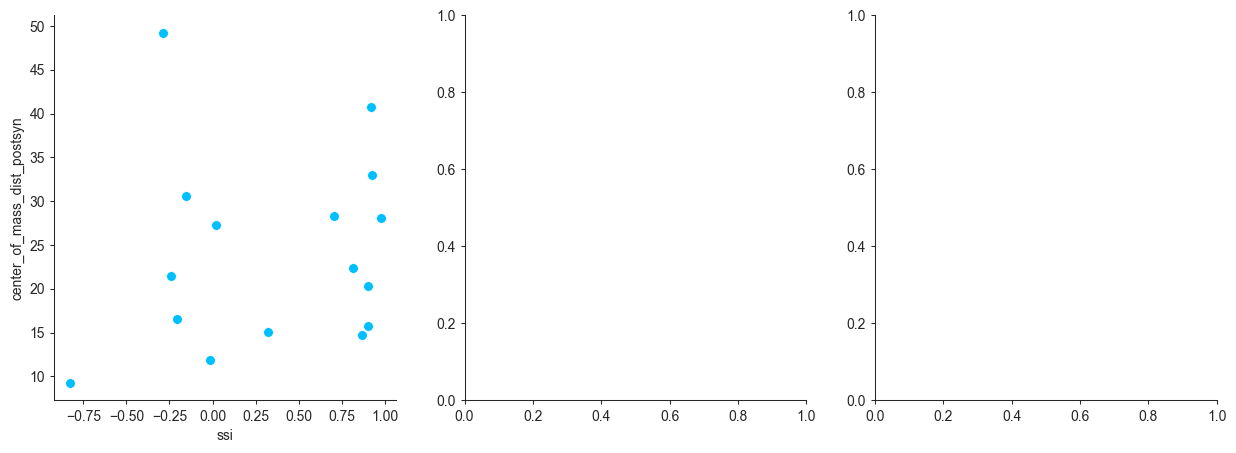

In [690]:
df_syns_with_soma_pos = dendritic_synapses.merge(correspondance_table[["pt_root_id", "soma_position_microns"]], how="left", left_on="post_pt_root_id", right_on="pt_root_id")
# df_syns_with_soma_pos = axonal_synapses.merge(correspondance_table[["pt_root_id", "soma_position_microns"]], how="left", left_on="pre_pt_root_id", right_on="pt_root_id")
df = pd.DataFrame(index=pt_root_ids)

def dist(a, b, type="euclidean"):
    # a = np.asarray(a)
    # b = np.asarray(b)
    # if np.isnan(a) or np.isnan(b):
    #     return np.nan
    if type == "euclidean":
        return np.sqrt(sum((a[i] - b[i])**2 for i in range(len(a))))
    else:
        return -1

for pt_root_id in pt_root_ids:
    d = df_syns_with_soma_pos[df_syns_with_soma_pos.post_pt_root_id == pt_root_id]
    n_syn = len(d)
    syn_dist = np.empty(n_syn)
    syn_size = np.empty(n_syn, dtype=int)
    center_of_mass = 0

    for i, (_, row) in enumerate(d.iterrows()): # Iterate through dendritic synapses
        pt_position = row["soma_position_microns"]
        syn_dist[i] = dist(row["position_microns"], pt_position)
        syn_size[i] = row["size"]
        center_of_mass += np.array(row["position_microns"] * row["size"]) # center of mass = sum(m_i * x_i) / sum(m_i)

    df.at[pt_root_id, "center_of_mass_dist_postsyn"] = dist(pt_position, center_of_mass / syn_size.sum())
    df.at[pt_root_id, "mean_syn_dist"] = syn_dist.mean()
    df.at[pt_root_id, "max_syn_dist"] = syn_dist.max()
    df.at[pt_root_id, "mean_syn_size"] = syn_size.mean()
    df.at[pt_root_id, "mean_norm_strength"] = (syn_size / syn_dist).mean()

df["ssi"] = metrics_corresponded[["pt_root_id", "ssi"]].set_index("pt_root_id")

df = df[pt_root_id_inclusion]

fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
sns.scatterplot(data=df, x="ssi", y="center_of_mass_dist_postsyn", c="deepskyblue", s=50, ax=axs[0])

df.head(10)

In [189]:
print(make_neuron_neuroglancer_link(client, 864691133065754585, show_inputs=True, show_outputs=True).data)

<a href="https://neuromancer-seung-import.appspot.com/?json_url=https://globalv1.em.brain.allentech.org/nglstate/api/v1/5695454536794112">Neuroglancer Link</a>


Check fraction of MC

In [691]:
cell_type_map = cell_type_table[["pt_root_id", "cell_type"]].drop_duplicates("pt_root_id").set_index("pt_root_id").squeeze() # convert to series
cell_type_map


pt_root_id
864691132773514104    PYC
864691132569667100    PYC
864691132985016672    PYC
864691132625300120    PYC
864691132689074198    PYC
                     ... 
864691133120998501    PYC
864691132735829608     BC
864691132653866455    PYC
864691132617158087    PYC
864691132762899335    PYC
Name: cell_type, Length: 3760, dtype: object

In [692]:
def merge_soma_position(df, root_id_col_name, soma_pos_col_name):
    soma_df = client.materialize.query_table("nucleus_detection_v0", filter_in_dict=dict(pt_root_id=df[root_id_col_name].values))
    soma_df.drop_duplicates("pt_root_id", inplace=True)
    soma_df[soma_pos_col_name] = soma_df["pt_position"].apply(lambda pos: transform_position_to_microns(pos, df=soma_df))
    return df.merge(soma_df[["pt_root_id", soma_pos_col_name]], how="left", left_on=root_id_col_name, right_on="pt_root_id")

In [ ]:
# merge_soma_position(dendritic_synapses, "pt_root_id", "soma_position_microns")

In [693]:
df_syns = dendritic_synapses.merge(correspondance_table[["pt_root_id", "soma_position_microns"]], how="left", left_on="post_pt_root_id", right_on="pt_root_id")
df_syns = merge_soma_position(df_syns, "pre_pt_root_id", "presyn_soma_position_microns")

In [694]:
df_syns

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,position_microns,pt_root_id_x,soma_position_microns,pt_root_id_y,presyn_soma_position_microns
0,368712094,t,91633437169304564,864691132731557484,91703805913512078,864691132734110999,709,"[80540, 64819, 5464]","[80603, 64845, 5466]","[80573, 64845, 5458]","[-125.11873092834873, 394.1609028630904, -342....",864691132734110999,"[-139.3642546681261, 391.097759012577, -325.61...",8.646911e+17,"[-272.6688521114327, 347.11194468531284, -185...."
1,390018716,t,92405844221793993,864691128500258808,92405844221805560,864691132940878257,1404,"[83251, 58561, 6264]","[83235, 58591, 6272]","[83234, 58592, 6266]","[-99.83126224453538, 345.2935474902975, -291.7...",864691132940878257,"[-72.29384663421858, 349.0251197986561, -317.5...",NaN,NaN
2,377079357,t,91771357225995930,864691132219851787,91771357225989769,864691132738257819,1018,"[80975, 54376, 5766]","[80991, 54369, 5767]","[80998, 54387, 5768]","[-121.82448492268706, 299.86041880423494, -302...",864691132738257819,"[-110.58683203977684, 357.3601754865111, -302....",NaN,NaN
3,450792024,t,95011961322039377,864691132626815134,95011961322028153,864691132779342959,152,"[92851, 67761, 3760]","[92857, 67796, 3754]","[92838, 67785, 3761]","[-6.221772035261733, 400.52654306500125, -424....",864691132779342959,"[-73.81490024855606, 370.7151199289942, -357.2...",NaN,NaN
4,351206058,t,91066845419424429,864691132690722815,91066845419431172,864691132807412738,1447,"[78329, 51288, 8174]","[78351, 51267, 8184]","[78365, 51279, 8182]","[-147.43155163366475, 300.1116466177567, -189....",864691132807412738,"[-74.19141538234277, 373.0233438254795, -248.6...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130556,440756567,t,94378299362838978,864691132772048788,94378299362844473,864691132833646702,282,"[90473, 66624, 6526]","[90456, 66605, 6531]","[90497, 66611, 6531]","[-29.400079768178518, 422.96271537782076, -301...",864691132833646702,"[-94.38347656930308, 369.84693808481364, -310....",8.646911e+17,"[-67.51787039386434, 497.67299006219685, -223...."
130557,381433569,t,92194600751917263,864691132878038197,92194600751913524,864691132661454821,2379,"[82586, 58015, 8003]","[82572, 58067, 7995]","[82563, 58030, 8002]","[-106.18334763932205, 361.1832340614565, -215....",864691132661454821,"[-53.32450737534801, 371.5466421131061, -297.0...",NaN,NaN
130558,455629737,t,95215577467511559,864691132233474408,95145277442801692,864691132851739966,3182,"[93422, 40059, 6657]","[93368, 40111, 6655]","[93393, 40090, 6654]","[-2.3791257499015193, 176.70580085429066, -227...",864691132851739966,"[-42.84882849963301, 355.78601151690447, -287....",NaN,NaN
130559,445400016,t,94729730967876161,864691132803073382,94729730967877187,864691132835126165,4161,"[91675, 65086, 7778]","[91699, 65038, 7779]","[91668, 65068, 7780]","[-17.341197014229255, 423.2908544703971, -243....",864691132835126165,"[-35.24621969533723, 370.9567484414983, -261.7...",NaN,NaN


In [695]:
pd.isna(df_syns[df_syns.post_pt_root_id == 864691132940878257].iloc[0]["presyn_soma_position_microns"])

True

In [698]:
def dist(x, y):
    # if pd.isna(x) or pd.isna(y):
    #     return np.nan
    return np.sqrt(sum((x[i] - y[i]) ** 2 for i in range(len(x))))

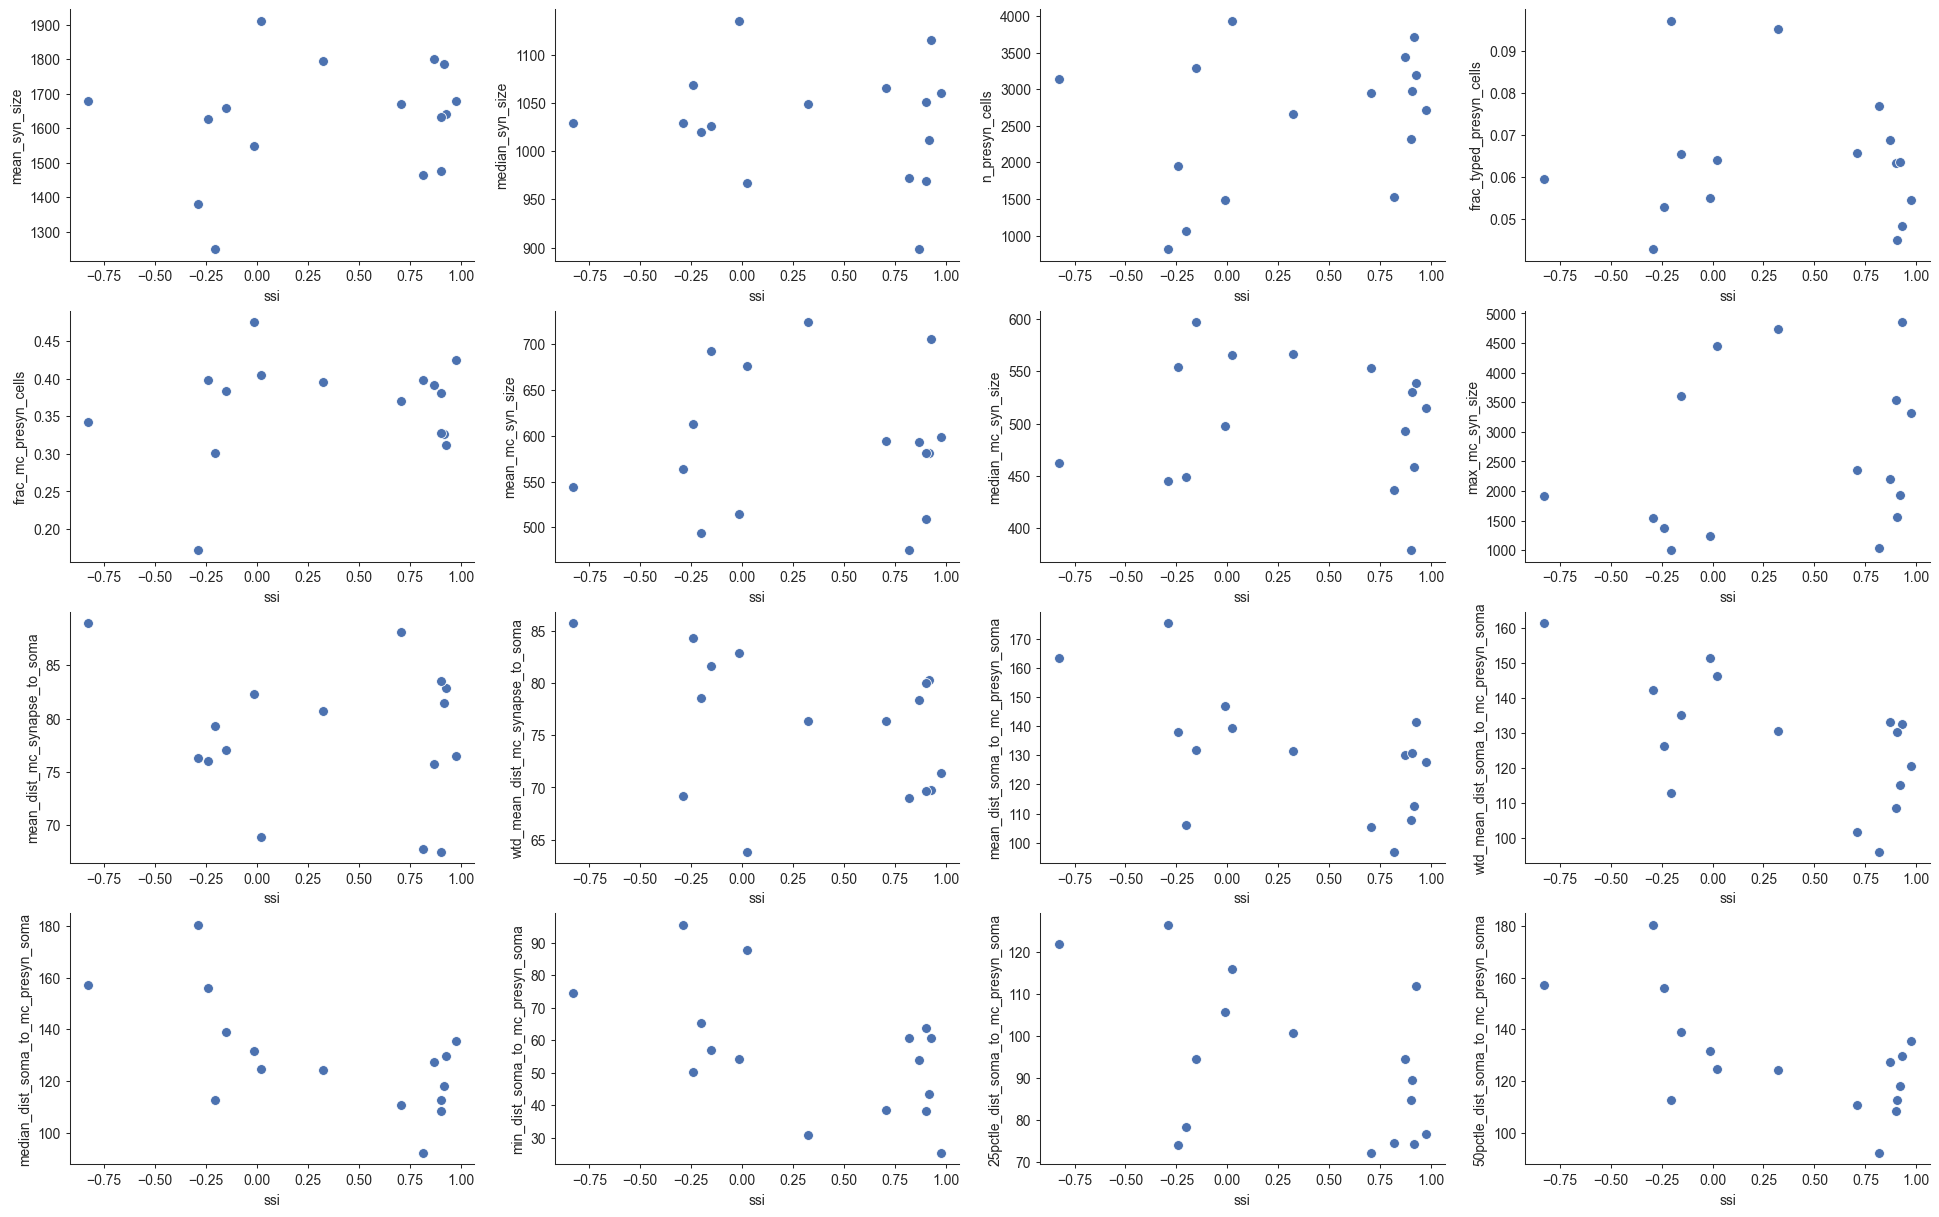

In [699]:
df = pd.DataFrame(index=pt_root_ids)

for pt_root_id in pt_root_ids:
    df_sub = df_syns[df_syns.post_pt_root_id == pt_root_id]
    n_tot = len(df_sub)
    df.loc[pt_root_id, "mean_syn_size"] = df_sub["size"].mean()
    df.loc[pt_root_id, "median_syn_size"] = df_sub["size"].median()
    
    df_sub = df_sub[df_sub.pre_pt_root_id.isin(cell_type_map.index)] # Filter by has cell type
    n_typed = len(df_sub)
    df.loc[pt_root_id, "n_presyn_cells"] = n_tot
    df.loc[pt_root_id, "frac_typed_presyn_cells"] = n_typed / n_tot
    
    df_sub = df_sub[(cell_type_map[df_sub.pre_pt_root_id] == "MC").values] # Filter by MC type
    n_mc = len(df_sub)
    df.loc[pt_root_id, "frac_mc_presyn_cells"] = n_mc / n_typed
    df.loc[pt_root_id, "mean_mc_syn_size"] = df_sub["size"].mean()
    df.loc[pt_root_id, "median_mc_syn_size"] = df_sub["size"].median()
    df.loc[pt_root_id, "max_mc_syn_size"] = df_sub["size"].max()

    soma_pos = df_sub.soma_position_microns.values[0]

    if soma_pos is not None: # If the current cell has a center position
        # Compute distance from this soma to each dendritic synapse
        df_sub["syn_dist_from_soma"] = df_sub.apply(lambda row: dist(row["position_microns"], row["soma_position_microns"]), axis=1)
        df.loc[pt_root_id, "mean_dist_mc_synapse_to_soma"] = df_sub.syn_dist_from_soma.mean()
        df.loc[pt_root_id, "wtd_mean_dist_mc_synapse_to_soma"] = np.average(df_sub.syn_dist_from_soma, weights=df_sub["size"])
        # df.loc[pt_root_id, "wtd_mean_synapse_size"] = np.average(df_sub["size"], weights=1/df_sub.syn_dist_from_soma)

        # Compute distance from this soma to each presynaptic soma
        df_sub["presyn_soma_dist"] = df_sub.apply(lambda row: dist(row["presyn_soma_position_microns"], row["soma_position_microns"]), axis=1)
        df.loc[pt_root_id, "mean_dist_soma_to_mc_presyn_soma"] = df_sub.presyn_soma_dist.mean()
        df.loc[pt_root_id, "wtd_mean_dist_soma_to_mc_presyn_soma"] = np.average(df_sub.presyn_soma_dist, weights=df_sub["size"])
        df.loc[pt_root_id, "median_dist_soma_to_mc_presyn_soma"] = df_sub.presyn_soma_dist.median()
        df.loc[pt_root_id, "min_dist_soma_to_mc_presyn_soma"] = df_sub.presyn_soma_dist.min()
        df.loc[pt_root_id, "25pctle_dist_soma_to_mc_presyn_soma"] = np.percentile(df_sub.presyn_soma_dist, 25)
        df.loc[pt_root_id, "50pctle_dist_soma_to_mc_presyn_soma"] = np.percentile(df_sub.presyn_soma_dist, 50)

df["ssi"] = metrics_corresponded[["pt_root_id", "ssi"]].set_index("pt_root_id")

df = df[pt_root_id_inclusion]

fig, axs = plt.subplots(figsize=(24, 15), nrows=4, ncols=4)
axs = axs.flatten()
for i, y in enumerate(df.columns[:-1]): # ignore "ssi" column
    sns.scatterplot(data=df, x="ssi", y=y, s=50, ax=axs[i])
# sns.scatterplot(data=df, x="ssi", y="frac_mc_presyn_cells", s=50, ax=axs[1])
# sns.scatterplot(data=df, x="ssi", y="mean_mc_syn_size", s=50, ax=axs[2])
# sns.scatterplot(data=df, x="ssi", y="mean_mc_presyn_soma_dist", s=50, ax=axs[3])
# sns.scatterplot(data=df, x="ssi", y="median_mc_presyn_soma_dist", s=50, ax=axs[4])
# sns.scatterplot(data=df, x="ssi", y="min_mc_presyn_soma_dist", s=50, ax=axs[5])

In [328]:
df.columns[:-1]

Index(['frac_typed_presyn_cells', 'frac_mc_presyn_cells'], dtype='object')

In [331]:
df_sub["size"]

404        187
4210       834
5475       335
5477       327
8468       226
          ... 
125384     575
127166     690
127342     267
129019     764
130966    1071
Name: size, Length: 72, dtype: int64

In [29]:
table = client.materialize.query_table("nucleus_detection_v0")
table.head(1)

201 - "Limited query to 200000 rows


,id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,228132,t,458.464831,87485049993200655,864691132737039043,"[632828, 749849, 738270]","[626620, 746124, 78876]","[638493, 753341, 80137]"


In [30]:
table.attrs

{'datastack_name': 'v1dd',
 'join_query': False,
 'table_name': 'nucleus_detection_v0',
 'table_schema': 'nucleus_detection',
 'table_valid': True,
 'table_aligned_volume': 'v1dd',
 'table_created': '2022-02-04T06:06:30.673697',
 'table_id': 2102,
 'table_schema_type': 'nucleus_detection',
 'table_user_id': '3',
 'table_notice_text': None,
 'table_flat_segmentation_source': 'precomputed://https://storage.googleapis.com/v1dd_imagery/v1dd_nuclei/segmentation',
 'table_write_permission': 'PRIVATE',
 'table_last_modified': '2022-10-27T17:28:14.043442',
 'table_description': 'This is the first version of nucleus detection from zetta, it includes all nucleus detections larger than 32 um^3. \r\nUploaded by Forrest Collman on Feb 3 2021.\r\n',
 'table_reference_table': None,
 'table_read_permission': 'PUBLIC',
 'table_voxel_resolution': [1.0, 1.0, 1.0],
 'dataframe_resolution': [1.0, 1.0, 1.0],
 'filters': {'inclusive': None,
  'exclusive': None,
  'equal': None,
  'spatial': None},
 'select_c

In [32]:
center_position_voxels = [632828, 749849, 738270]
radius_microns = 100
radius_nm = radius_microns * 1000
nm_per_voxel = np.array(table.attrs["table_voxel_resolution"], dtype=int)
radius_voxels = nm_per_voxel * radius_nm
min_pos = center_position_voxels - radius_voxels
max_pos = center_position_voxels + radius_voxels

nuclei_in_box = client.materialize.query_table("nucleus_detection_v0", filter_spatial_dict=dict(pt_position=[min_pos, max_pos]))
len(nuclei_in_box)

1071

In [39]:
nuclei_in_box.query("pt_root_id == 864691132669047247")
nuclei_in_box.value_counts("pt_root_id")

,id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
2,152238,t,155.573223,85656287211421667,864691132669047247,"[569972, 778561, 722970]","[563143, 770102, 77610]","[576335, 784226, 78463]"
34,228574,t,40.832772,86005588445956441,864691132669047247,"[582388, 686760, 772605]","[575714, 683734, 83037]","[589062, 689864, 83595]"
41,153346,t,198.899275,85585025248526357,864691132669047247,"[565937, 747055, 783450]","[560505, 743253, 84041]","[572145, 752565, 84797]"
45,241640,t,32.426726,86149555615397687,864691132669047247,"[587432, 805100, 721575]","[583707, 799125, 77615]","[590924, 810610, 77959]"
65,228630,t,359.421933,87344862328148575,864691132669047247,"[627706, 768783, 775980]","[622430, 764748, 83042]","[633449, 773284, 84181]"
79,228743,t,39.605778,86005313634905566,864691132669047247,"[582854, 679078, 785430]","[577654, 675974, 84395]","[588518, 682880, 84885]"
161,228980,t,98.786551,87273256700297645,864691132669047247,"[625611, 724784, 791145]","[621343, 721059, 85074]","[630112, 729673, 85389]"
231,228826,t,354.253276,88048549769993648,864691132669047247,"[652849, 769870, 778275]","[646796, 764981, 83299]","[660454, 775069, 84448]"
233,153594,t,44.275833,85303619057975766,864691132669047247,"[556702, 750392, 787365]","[551814, 747210, 84642]","[561514, 753651, 85020]"
370,228677,t,33.552916,88678776090926911,864691132669047247,"[676827, 656962, 768240]","[672714, 651840, 82571]","[685130, 660919, 83027]"


In [7]:
client.materialize

In [20]:
client.materialize.query_table("nucleus_detection_v0", filter_equal_dict=dict(pt_root_id=864691132668760081))

,id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,295073,t,274.744998,93181549675621607,864691132668760081,"[834122, 627086, 297585]","[830087, 623749, 31544]","[838701, 630500, 32636]"


In [17]:
client.materialize.query_table("ariadne_dendrite_proofreading_v2")

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,2325,t,ariadne_dendrite_pf,in_progress,92123750232983926,864691132697978758,"[88676, 60616, 2224]"
1,2236,t,ariadne_dendrite_pf,not_started,91487614775408720,864691132737580889,"[86075, 49442, 8100]"
2,2192,t,ariadne_dendrite_pf,allen_qa,94588924424556182,864691132618367687,"[98405, 69670, 5246]"
3,2613,t,ariadne_dendrite_pf,allen_qa,94659293168718993,864691132618367687,"[98501, 69803, 5233]"
4,2139,t,ariadne_dendrite_pf,in_progress,96212834715211256,864691132808110369,"[104675, 91468, 8099]"
...,...,...,...,...,...,...,...
2326,2588,t,ariadne_dendrite_pf,allen_qa,91421231626567680,864691132669322924,"[86005, 65529, 7100]"
2327,4133,t,ariadne_dendrite_pf,ariadne_qa,89593774716025301,864691132638628240,"[78691, 73938, 8100]"
2328,3070,t,ariadne_dendrite_pf,allen_qa,93181480956013302,864691132668760081,"[92868, 69477, 6538]"
2329,3771,t,ariadne_dendrite_pf,ariadne_qa,98101039441952580,864691132671993301,"[112031, 44480, 5600]"


In [10]:
client.materialize.get_tables()

['ariadne_axon_task',
 'correspondance_pilot',
 'ariadne_multisoma_proofreading_v1',
 'ariadne_dendrite_proofreading_v2',
 'ariadne_axon_proofreading_v1',
 'synapses_v1dd',
 'multisoma_split_task',
 'ariadne_dendrite_task',
 'ophys_examples',
 'manual_central_types',
 'nucleus_detection_v0']